# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Bryan Herdianto
- Email: bryan.herdianto17@gmail.com
- ID Dicoding: bryanherdianto

## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [2]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

### Menyiapkan data yang akan digunakan

In [3]:
spark = SparkSession.builder.appName('dropout_scoring_analytics').config("spark.jars", "postgresql-42.7.3.jar").getOrCreate()
spark

In [4]:
df = spark.read.csv("data.csv", inferSchema=True, header=True, sep=';')

#### Penjelasan Dataset

A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies. The dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. The data is used to build classification models to predict students' dropout and academic sucess.

| Column name | Description |
| --- | --- |
|Marital status | The marital status of the student. (Categorical) 1 – single 2 – married 3 – widower 4 – divorced 5 – facto union 6 – legally separated |
| Application mode | The method of application used by the student. (Categorical) 1 - 1st phase - general contingent 2 - Ordinance No. 612/93 5 - 1st phase - special contingent (Azores Island) 7 - Holders of other higher courses 10 - Ordinance No. 854-B/99 15 - International student (bachelor) 16 - 1st phase - special contingent (Madeira Island) 17 - 2nd phase - general contingent 18 - 3rd phase - general contingent 26 - Ordinance No. 533-A/99, item b2) (Different Plan) 27 - Ordinance No. 533-A/99, item b3 (Other Institution) 39 - Over 23 years old 42 - Transfer 43 - Change of course 44 - Technological specialization diploma holders 51 - Change of institution/course 53 - Short cycle diploma holders 57 - Change of institution/course (International)|
|Application order | The order in which the student applied. (Numerical) Application order (between 0 - first choice; and 9 last choice) |
|Course | The course taken by the student. (Categorical) 33 - Biofuel Production Technologies 171 - Animation and Multimedia Design 8014 - Social Service (evening attendance) 9003 - Agronomy 9070 - Communication Design 9085 - Veterinary Nursing 9119 - Informatics Engineering 9130 - Equinculture 9147 - Management 9238 - Social Service 9254 - Tourism 9500 - Nursing 9556 - Oral Hygiene 9670 - Advertising and Marketing Management 9773 - Journalism and Communication 9853 - Basic Education 9991 - Management (evening attendance)|
|Daytime/evening attendance | Whether the student attends classes during the day or in the evening. (Categorical) 1 – daytime 0 - evening |
|Previous qualification| The qualification obtained by the student before enrolling in higher education. (Categorical) 1 - Secondary education 2 - Higher education - bachelor's degree 3 - Higher education - degree 4 - Higher education - master's 5 - Higher education - doctorate 6 - Frequency of higher education 9 - 12th year of schooling - not completed 10 - 11th year of schooling - not completed 12 - Other - 11th year of schooling 14 - 10th year of schooling 15 - 10th year of schooling - not completed 19 - Basic education 3rd cycle (9th/10th/11th year) or equiv. 38 - Basic education 2nd cycle (6th/7th/8th year) or equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 42 - Professional higher technical course 43 - Higher education - master (2nd cycle) |
|Previous qualification (grade) | Grade of previous qualification (between 0 and 200) |
| Nacionality | The nationality of the student. (Categorical) 1 - Portuguese; 2 - German; 6 - Spanish; 11 - Italian; 13 - Dutch; 14 - English; 17 - Lithuanian; 21 - Angolan; 22 - Cape Verdean; 24 - Guinean; 25 - Mozambican; 26 - Santomean; 32 - Turkish; 41 - Brazilian; 62 - Romanian; 100 - Moldova (Republic of); 101 - Mexican; 103 - Ukrainian; 105 - Russian; 108 - Cuban; 109 - Colombian|
|Mother's qualification | The qualification of the student's mother. (Categorical) 1 - Secondary Education - 12th Year of Schooling or Eq. 2 - Higher Education - Bachelor's Degree 3 - Higher Education - Degree 4 - Higher Education - Master's 5 - Higher Education - Doctorate 6 - Frequency of Higher Education 9 - 12th Year of Schooling - Not Completed 10 - 11th Year of Schooling - Not Completed 11 - 7th Year (Old) 12 - Other - 11th Year of Schooling 14 - 10th Year of Schooling 18 - General commerce course 19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv. 22 - Technical-professional course 26 - 7th year of schooling 27 - 2nd cycle of the general high school course 29 - 9th Year of Schooling - Not Completed 30 - 8th year of schooling 34 - Unknown 35 - Can't read or write 36 - Can read without having a 4th year of schooling 37 - Basic education 1st cycle (4th/5th year) or equiv. 38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 41 - Specialized higher studies course 42 - Professional higher technical course 43 - Higher Education - Master (2nd cycle) 44 - Higher Education - Doctorate (3rd cycle)|
|Father's qualification | The qualification of the student's father. (Categorical) 1 - Secondary Education - 12th Year of Schooling or Eq. 2 - Higher Education - Bachelor's Degree 3 - Higher Education - Degree 4 - Higher Education - Master's 5 - Higher Education - Doctorate 6 - Frequency of Higher Education 9 - 12th Year of Schooling - Not Completed 10 - 11th Year of Schooling - Not Completed 11 - 7th Year (Old) 12 - Other - 11th Year of Schooling 13 - 2nd year complementary high school course 14 - 10th Year of Schooling 18 - General commerce course 19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv. 20 - Complementary High School Course 22 - Technical-professional course 25 - Complementary High School Course - not concluded 26 - 7th year of schooling 27 - 2nd cycle of the general high school course 29 - 9th Year of Schooling - Not Completed 30 - 8th year of schooling 31 - General Course of Administration and Commerce 33 - Supplementary Accounting and Administration 34 - Unknown 35 - Can't read or write 36 - Can read without having a 4th year of schooling 37 - Basic education 1st cycle (4th/5th year) or equiv. 38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 39 - Technological specialization course 40 - Higher education - degree (1st cycle) 41 - Specialized higher studies course 42 - Professional higher technical course 43 - Higher Education - Master (2nd cycle) 44 - Higher Education - Doctorate (3rd cycle) |
| Mother's occupation | The occupation of the student's mother. (Categorical) 0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 122 - Health professionals 123 - teachers 125 - Specialists in information and communication technologies (ICT) 131 - Intermediate level science and engineering technicians and professions 132 - Technicians and professionals, of intermediate level of health 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 141 - Office workers, secretaries in general and data processing operators 143 - Data, accounting, statistical, financial services and registry-related operators 144 - Other administrative support staff 151 - personal service workers 152 - sellers 153 - Personal care workers and the like 171 - Skilled construction workers and the like, except electricians 173 - Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like 175 - Workers in food processing, woodworking, clothing and other industries and crafts 191 - cleaning workers 192 - Unskilled workers in agriculture, animal production, fisheries and forestry 193 - Unskilled workers in extractive industry, construction, manufacturing and transport 194 - Meal preparation assistants |
| Father's occupation | The occupation of the student's father. (Categorical) 0 - Student 1 - Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers 2 - Specialists in Intellectual and Scientific Activities 3 - Intermediate Level Technicians and Professions 4 - Administrative staff 5 - Personal Services, Security and Safety Workers and Sellers 6 - Farmers and Skilled Workers in Agriculture, Fisheries and Forestry 7 - Skilled Workers in Industry, Construction and Craftsmen 8 - Installation and Machine Operators and Assembly Workers 9 - Unskilled Workers 10 - Armed Forces Professions 90 - Other Situation 99 - (blank) 101 - Armed Forces Officers 102 - Armed Forces Sergeants 103 - Other Armed Forces personnel 112 - Directors of administrative and commercial services 114 - Hotel, catering, trade and other services directors 121 - Specialists in the physical sciences, mathematics, engineering and related techniques 122 - Health professionals 123 - teachers 124 - Specialists in finance, accounting, administrative organization, public and commercial relations 131 - Intermediate level science and engineering technicians and professions 132 - Technicians and professionals, of intermediate level of health 134 - Intermediate level technicians from legal, social, sports, cultural and similar services 135 - Information and communication technology technicians 141 - Office workers, secretaries in general and data processing operators 143 - Data, accounting, statistical, financial services and registry-related operators 144 - Other administrative support staff 151 - personal service workers 152 - sellers 153 - Personal care workers and the like 154 - Protection and security services personnel 161 - Market-oriented farmers and skilled agricultural and animal production workers 163 - Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence 171 - Skilled construction workers and the like, except electricians 172 - Skilled workers in metallurgy, metalworking and similar 174 - Skilled workers in electricity and electronics 175 - Workers in food processing, woodworking, clothing and other industries and crafts 181 - Fixed plant and machine operators 182 - assembly workers 183 - Vehicle drivers and mobile equipment operators 192 - Unskilled workers in agriculture, animal production, fisheries and forestry 193 - Unskilled workers in extractive industry, construction, manufacturing and transport 194 - Meal preparation assistants 195 - Street vendors (except food) and street service providers |
| Admission grade | Admission grade (between 0 and 200) |
| Displaced | Whether the student is a displaced person. (Categorical) 	1 – yes 0 – no |
| Educational special needs | Whether the student has any special educational needs. (Categorical) 1 – yes 0 – no |
|Debtor | Whether the student is a debtor. (Categorical) 1 – yes 0 – no|
|Tuition fees up to date | Whether the student's tuition fees are up to date. (Categorical) 1 – yes 0 – no|
|Gender | The gender of the student. (Categorical) 1 – male 0 – female |
|Scholarship holder | Whether the student is a scholarship holder. (Categorical) 1 – yes 0 – no |
|Age at enrollment | The age of the student at the time of enrollment. (Numerical)|
|International | Whether the student is an international student. (Categorical) 1 – yes 0 – no|
|Curricular units 1st sem (credited) | The number of curricular units credited by the student in the first semester. (Numerical) |
| Curricular units 1st sem (enrolled) | The number of curricular units enrolled by the student in the first semester. (Numerical) |
| Curricular units 1st sem (evaluations) | The number of curricular units evaluated by the student in the first semester. (Numerical) |
| Curricular units 1st sem (approved) | The number of curricular units approved by the student in the first semester. (Numerical) |

#### Data Cleaning

In [5]:
# inspect all the column names and their type
df.printSchema()

root
 |-- Marital_status: integer (nullable = true)
 |-- Application_mode: integer (nullable = true)
 |-- Application_order: integer (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime_evening_attendance: integer (nullable = true)
 |-- Previous_qualification: integer (nullable = true)
 |-- Previous_qualification_grade: double (nullable = true)
 |-- Nacionality: integer (nullable = true)
 |-- Mothers_qualification: integer (nullable = true)
 |-- Fathers_qualification: integer (nullable = true)
 |-- Mothers_occupation: integer (nullable = true)
 |-- Fathers_occupation: integer (nullable = true)
 |-- Admission_grade: double (nullable = true)
 |-- Displaced: integer (nullable = true)
 |-- Educational_special_needs: integer (nullable = true)
 |-- Debtor: integer (nullable = true)
 |-- Tuition_fees_up_to_date: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Scholarship_holder: integer (nullable = true)
 |-- Age_at_enrollment: integer (nullable = true)


In [6]:
# find the total amount of columns
len(df.dtypes)

37

In [7]:
# split the columns into several list to avoid messy output
numeric_cols_1 = [c for c, t in df.dtypes if t.startswith('string') == False][:7]
numeric_cols_2 = [c for c, t in df.dtypes if t.startswith('string') == False][7:14]
numeric_cols_3 = [c for c, t in df.dtypes if t.startswith('string') == False][14:21]
numeric_cols_4 = [c for c, t in df.dtypes if t.startswith('string') == False][21:26]
numeric_cols_5 = [c for c, t in df.dtypes if t.startswith('string') == False][26:30]
numeric_cols_6 = [c for c, t in df.dtypes if t.startswith('string') == False][30:]

df.select(*numeric_cols_1).summary().show()
df.select(*numeric_cols_2).summary().show()
df.select(*numeric_cols_3).summary().show()
df.select(*numeric_cols_4).summary().show()
df.select(*numeric_cols_5).summary().show()
df.select(*numeric_cols_6).summary().show()

+-------+------------------+------------------+------------------+-----------------+--------------------------+----------------------+----------------------------+
|summary|    Marital_status|  Application_mode| Application_order|           Course|Daytime_evening_attendance|Previous_qualification|Previous_qualification_grade|
+-------+------------------+------------------+------------------+-----------------+--------------------------+----------------------+----------------------------+
|  count|              4424|              4424|              4424|             4424|                      4424|                  4424|                        4424|
|   mean|1.1785714285714286|18.669077757685354|1.7278481012658229|8856.642631103074|        0.8908227848101266|     4.577757685352622|           132.6133137432175|
| stddev|0.6057469461307102|17.484682291004752|1.3137930783622085| 2063.56641619752|        0.3118966814817876|     10.21659234126795|          13.188331685876214|
|    min|       

In [9]:
# filter status enrolled
df = df.filter(~(df["Status"] == "Enrolled"))

In [10]:
# find total duplicates
print("Jumlah duplikasi: ", (df.count() - df.distinct().count()))

Jumlah duplikasi:  0


In [5]:
# Mapping dictionary
international_map = {
    1: "yes",
    0: "no"
}

scholarship_holder_map = {
    1: "yes",
    0: "no"
}

gender_map = {
    1: "male",
    0: "female"
}

tuition_fees_map = {
    1: "yes",
    0: "no"
}

debtor_map = {
    1: "yes", 
    0: "no"
}

education_special_needs_map = {
    1: "yes", 
    0: "no"
}

displaced_map = {
    1: "yes", 
    0: "no"
}

father_occupation_map = {
    0: "Student",
    1: "Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers",
    2: "Specialists in Intellectual and Scientific Activities",
    3: "Intermediate Level Technicians and Professions",
    4: "Administrative staff",
    5: "Personal Services, Security and Safety Workers and Sellers",
    6: "Farmers and Skilled Workers in Agriculture, Fisheries and Forestry",
    7: "Skilled Workers in Industry, Construction and Craftsmen",
    8: "Installation and Machine Operators and Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces Professions",
    90: "Other Situation",
    99: "(blank)",
    101: "Armed Forces Officers",
    102: "Armed Forces Sergeants",
    103: "Other Armed Forces personnel",
    112: "Directors of administrative and commercial services",
    114: "Hotel, catering, trade and other services directors",
    121: "Specialists in the physical sciences, mathematics, engineering and related techniques",
    122: "Health professionals",
    123: "teachers",
    124: "Specialists in finance, accounting, administrative organization, public and commercial relations",
    131: "Intermediate level science and engineering technicians and professions",
    132: "Technicians and professionals, of intermediate level of health",
    134: "Intermediate level technicians from legal, social, sports, cultural and similar services",
    135: "Information and communication technology technicians",
    141: "Office workers, secretaries in general and data processing operators",
    143: "Data, accounting, statistical, financial services and registry-related operators",
    144: "Other administrative support staff",
    151: "personal service workers",
    152: "sellers",
    153: "Personal care workers and the like",
    154: "Protection and security services personnel",
    161: "Market-oriented farmers and skilled agricultural and animal production workers",
    163: "Farmers, livestock keepers, fishermen, hunters and gatherers, subsistence",
    171: "Skilled construction workers and the like, except electricians",
    172: "Skilled workers in metallurgy, metalworking and similar",
    174: "Skilled workers in electricity and electronics",
    175: "Workers in food processing, woodworking, clothing and other industries and crafts",
    181: "Fixed plant and machine operators",
    182: "assembly workers",
    183: "Vehicle drivers and mobile equipment operators",
    192: "Unskilled workers in agriculture, animal production, fisheries and forestry",
    193: "Unskilled workers in extractive industry, construction, manufacturing and transport",
    194: "Meal preparation assistants",
    195: "Street vendors (except food) and street service providers",
}

mother_occupation_map = {
    0: "Student",
    1: "Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers",
    2: "Specialists in Intellectual and Scientific Activities",
    3: "Intermediate Level Technicians and Professions",
    4: "Administrative staff",
    5: "Personal Services, Security and Safety Workers and Sellers",
    6: "Farmers and Skilled Workers in Agriculture, Fisheries and Forestry",
    7: "Skilled Workers in Industry, Construction and Craftsmen",
    8: "Installation and Machine Operators and Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces Professions",
    90: "Other Situation",
    99: "(blank)",
    122: "Health professionals",
    123: "teachers",
    125: "Specialists in information and communication technologies (ICT)",
    131: "Intermediate level science and engineering technicians and professions",
    132: "Technicians and professionals, of intermediate level of health",
    134: "Intermediate level technicians from legal, social, sports, cultural and similar services",
    141: "Office workers, secretaries in general and data processing operators",
    143: "Data, accounting, statistical, financial services and registry-related operators",
    144: "Other administrative support staff",
    151: "personal service workers",
    152: "sellers",
    153: "Personal care workers and the like",
    171: "Skilled construction workers and the like, except electricians",
    173: "Skilled workers in printing, precision instrument manufacturing, jewelers, artisans and the like",
    175: "Workers in food processing, woodworking, clothing and other industries and crafts",
    191: "cleaning workers",
    192: "Unskilled workers in agriculture, animal production, fisheries and forestry",
    193: "Unskilled workers in extractive industry, construction, manufacturing and transport",
    194: "Meal preparation assistants",
}

father_qualification_map = {
    1: "Secondary Education - 12th Year of Schooling or Eq.",
    2: "Higher Education - Bachelor's Degree",
    3: "Higher Education - Degree",
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: "Frequency of Higher Education",
    9: "12th Year of Schooling - Not Completed",
    10: "11th Year of Schooling - Not Completed",
    11: "7th Year (Old)",
    12: "Other - 11th Year of Schooling",
    14: "10th Year of Schooling",
    18: "General commerce course",
    19: "Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.",
    22: "Technical-professional course",
    26: "7th year of schooling",
    27: "2nd cycle of the general high school course",
    29: "9th Year of Schooling - Not Completed",
    30: "8th year of schooling",
    34: "Unknown",
    35: "Can't read or write",
    36: "Can read without having a 4th year of schooling",
    37: "Basic education 1st cycle (4th/5th year) or equiv.",
    38: "Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.",
    39: "Technological specialization course",
    40: "Higher education - degree (1st cycle)",
    41: "Specialized higher studies course",
    42: "Professional higher technical course",
    43: "Higher Education - Master (2nd cycle)",
    44: "Higher Education - Doctorate (3rd cycle)",
}

mother_qualification_map = {
    1: "Secondary Education - 12th Year of Schooling or Eq.",
    2: "Higher Education - Bachelor's Degree",
    3: "Higher Education - Degree",
    4: "Higher Education - Master's",
    5: "Higher Education - Doctorate",
    6: "Frequency of Higher Education",
    9: "12th Year of Schooling - Not Completed",
    10: "11th Year of Schooling - Not Completed",
    11: "7th Year (Old)",
    12: "Other - 11th Year of Schooling",
    14: "10th Year of Schooling",
    18: "General commerce course",
    19: "Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.",
    22: "Technical-professional course",
    26: "7th year of schooling",
    27: "2nd cycle of the general high school course",
    29: "9th Year of Schooling - Not Completed",
    30: "8th year of schooling",
    34: "Unknown",
    35: "Can't read or write",
    36: "Can read without having a 4th year of schooling",
    37: "Basic education 1st cycle (4th/5th year) or equiv.",
    38: "Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.",
    39: "Technological specialization course",
    40: "Higher education - degree (1st cycle)",
    41: "Specialized higher studies course",
    42: "Professional higher technical course",
    43: "Higher Education - Master (2nd cycle)",
    44: "Higher Education - Doctorate (3rd cycle)",
}

daytime_evening_attendance_map = {
    1: "daytime", 
    0: "evening"
}

nationality_map = {
    1: "Portuguese",
    2: "German",
    6: "Spanish",
    11: "Italian",
    13: "Dutch",
    14: "English",
    17: "Lithuanian",
    21: "Angolan",
    22: "Cape Verdean",
    24: "Guinean",
    25: "Mozambican",
    26: "Santomean",
    32: "Turkish",
    41: "Brazilian",
    62: "Romanian",
    100: "Moldova (Republic of)",
    101: "Mexican",
    103: "Ukrainian",
    105: "Russian",
    108: "Cuban",
    109: "Colombian",
}

previous_qualification_map = {
    1: "Secondary education",
    2: "Higher education - bachelor's degree",
    3: "Higher education - degree",
    4: "Higher education - master's",
    5: "Higher education - doctorate",
    6: "Frequency of higher education",
    9: "12th year of schooling - not completed",
    10: "11th year of schooling - not completed",
    12: "Other - 11th year of schooling",
    14: "10th year of schooling",
    15: "10th year of schooling - not completed",
    19: "Basic education 3rd cycle (9th/10th/11th year) or equiv.",
    38: "Basic education 2nd cycle (6th/7th/8th year) or equiv.",
    39: "Technological specialization course",
    40: "Higher education - degree (1st cycle)",
    42: "Professional higher technical course",
    43: "Higher education - master (2nd cycle)",
}

course_map = {
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)",
}

application_order_map = {
    0: "first choice",
    1: "second choice",
    2: "third choice",
    3: "fourth choice",
    4: "fifth choice",
    5: "sixth choice",
    6: "seventh choice",
    7: "eighth choice",
    8: "ninth choice",
    9: "last choice",
}

application_mode_map = {
    1: "1st phase - general contingent",
    2: "Ordinance No. 612/93",
    5: "1st phase - special contingent (Azores Island)",
    7: "Holders of other higher courses",
    10: "Ordinance No. 854-B/99",
    15: "International student (bachelor)",
    16: "1st phase - special contingent (Madeira Island)",
    17: "2nd phase - general contingent",
    18: "3rd phase - general contingent",
    26: "Ordinance No. 533-A/99, item b2 (Different Plan)",
    27: "Ordinance No. 533-A/99, item b3 (Other Institution)",
    39: "Over 23 years old",
    42: "Transfer",
    43: "Change of course",
    44: "Technological specialization diploma holders",
    51: "Change of institution/course",
    53: "Short cycle diploma holders",
    57: "Change of institution/course (International)",
}

marital_status_map = {
    1: "single",
    2: "married",
    3: "widower",
    4: "divorced",
    5: "facto union",
    6: "legally separated",
}

# Define UDF to map integer to string using the dictionary
def map_int_to_str_international(value):
    return international_map.get(value, str(value))

def map_int_to_str_scholar(value):
    return scholarship_holder_map.get(value, str(value))

def map_int_to_str_gender(value):
    return gender_map.get(value, str(value))

def map_int_to_str_tuition(value):
    return tuition_fees_map.get(value, str(value))

def map_int_to_str_debtor(value):
    return debtor_map.get(value, str(value))

def map_int_to_str_education(value):
    return education_special_needs_map.get(value, str(value))

def map_int_to_str_displaced(value):
    return displaced_map.get(value, str(value))

def map_int_to_str_father_occupation(value):
    return father_occupation_map.get(value, str(value))

def map_int_to_str_mother_occupation(value):
    return mother_occupation_map.get(value, str(value))

def map_int_to_str_father_qualification(value):
    return father_qualification_map.get(value, str(value))

def map_int_to_str_mother_qualification(value):
    return mother_qualification_map.get(value, str(value))

def map_int_to_str_attendance(value):
    return daytime_evening_attendance_map.get(value, str(value))

def map_int_to_str_nationality(value):
    return nationality_map.get(value, str(value))

def map_int_to_str_prev_qualification(value):
    return previous_qualification_map.get(value, str(value))

def map_int_to_str_course(value):
    return course_map.get(value, str(value))

def map_int_to_str_app_order(value):
    return application_order_map.get(value, str(value))

def map_int_to_str_app_mode(value):
    return application_mode_map.get(value, str(value))

def map_int_to_str_marital(value):
    return marital_status_map.get(value, str(value))

# Register UDF
map_udf_international = udf(map_int_to_str_international, StringType())
map_udf_scholar = udf(map_int_to_str_scholar, StringType())
map_udf_gender = udf(map_int_to_str_gender, StringType())
map_udf_tuition = udf(map_int_to_str_tuition, StringType())
map_udf_debtor = udf(map_int_to_str_debtor, StringType())
map_udf_education = udf(map_int_to_str_education, StringType())
map_udf_displaced = udf(map_int_to_str_displaced, StringType())
map_udf_father_occupation = udf(map_int_to_str_father_occupation, StringType())
map_udf_mother_occupation = udf(map_int_to_str_mother_occupation, StringType())
map_udf_father_qualification = udf(map_int_to_str_father_qualification, StringType())
map_udf_mother_qualification = udf(map_int_to_str_mother_qualification, StringType())
map_udf_attendance = udf(map_int_to_str_attendance, StringType())
map_udf_nationality = udf(map_int_to_str_nationality, StringType())
map_udf_prev_qualification = udf(map_int_to_str_prev_qualification, StringType())
map_udf_course = udf(map_int_to_str_course, StringType())
map_udf_app_order = udf(map_int_to_str_app_order, StringType())
map_udf_app_mode = udf(map_int_to_str_app_mode, StringType())
map_udf_marital = udf(map_int_to_str_marital, StringType())

# Apply UDF to the old column
new_df = df
new_df = new_df.withColumn('International', map_udf_international(new_df['International']))
new_df = new_df.withColumn('Scholarship_holder', map_udf_scholar(new_df['Scholarship_holder']))
new_df = new_df.withColumn('Gender', map_udf_gender(new_df['Gender']))
new_df = new_df.withColumn('Tuition_fees_up_to_date', map_udf_tuition(new_df['Tuition_fees_up_to_date']))
new_df = new_df.withColumn('Debtor', map_udf_debtor(new_df['Debtor']))
new_df = new_df.withColumn('Educational_special_needs', map_udf_education(new_df['Educational_special_needs']))
new_df = new_df.withColumn('Displaced', map_udf_displaced(new_df['Displaced']))
new_df = new_df.withColumn('Fathers_occupation', map_udf_father_occupation(new_df['Fathers_occupation']))
new_df = new_df.withColumn('Mothers_occupation', map_udf_mother_occupation(new_df['Mothers_occupation']))
new_df = new_df.withColumn('Fathers_qualification', map_udf_father_qualification(new_df['Fathers_qualification']))
new_df = new_df.withColumn('Mothers_qualification', map_udf_mother_qualification(new_df['Mothers_qualification']))
new_df = new_df.withColumn('Daytime_evening_attendance', map_udf_attendance(new_df['Daytime_evening_attendance']))
new_df = new_df.withColumn('Nacionality', map_udf_nationality(new_df['Nacionality']))
new_df = new_df.withColumn('Previous_qualification', map_udf_prev_qualification(new_df['Previous_qualification']))
new_df = new_df.withColumn('Course', map_udf_course(new_df['Course']))
new_df = new_df.withColumn('Application_order', map_udf_app_order(new_df['Application_order']))
new_df = new_df.withColumn('Application_mode', map_udf_app_mode(new_df['Application_mode']))
new_df = new_df.withColumn('Marital_status', map_udf_marital(new_df['Marital_status']))

## Data Understanding

In [14]:
df.select('Status').show()

+--------+
|  Status|
+--------+
| Dropout|
|Graduate|
| Dropout|
|Graduate|
|Graduate|
|Graduate|
|Graduate|
| Dropout|
|Graduate|
| Dropout|
|Graduate|
|Graduate|
| Dropout|
|Graduate|
|Graduate|
| Dropout|
|Graduate|
|Graduate|
|Graduate|
|Graduate|
+--------+
only showing top 20 rows



In [15]:
df.select('Unemployment_rate').show()

+-----------------+
|Unemployment_rate|
+-----------------+
|             10.8|
|             13.9|
|             10.8|
|              9.4|
|             13.9|
|             16.2|
|             15.5|
|             15.5|
|             16.2|
|              8.9|
|             13.9|
|             12.7|
|             12.7|
|              8.9|
|             10.8|
|             15.5|
|             15.5|
|             10.8|
|             11.1|
|             12.7|
+-----------------+
only showing top 20 rows



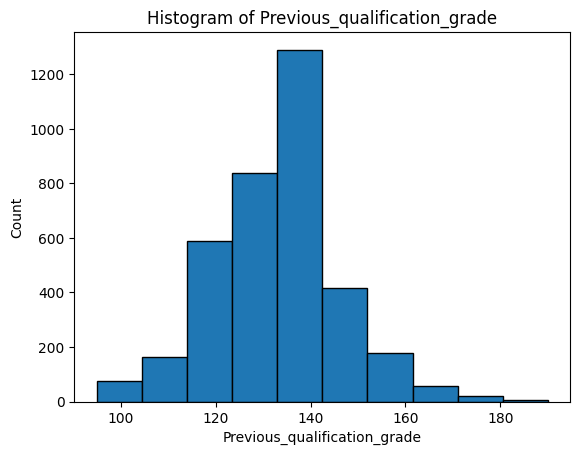

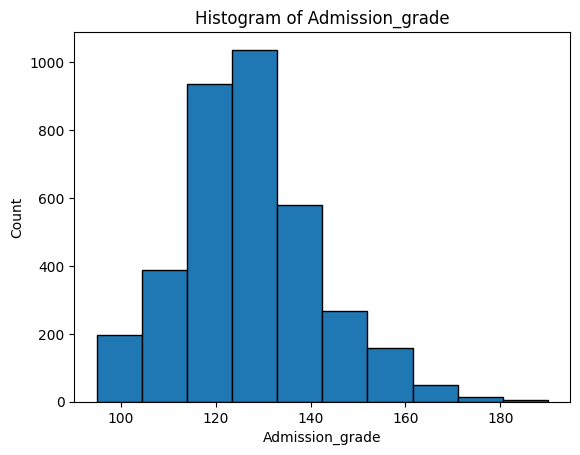

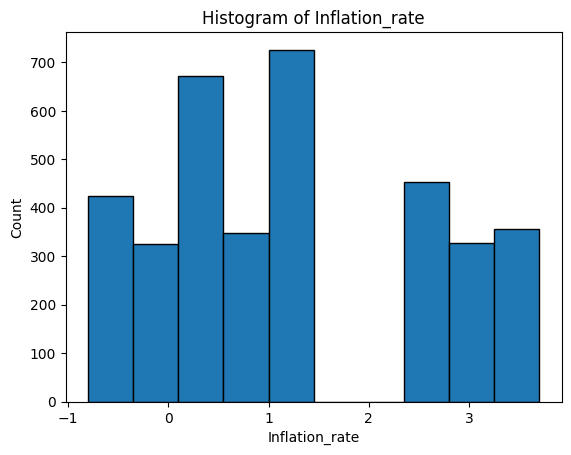

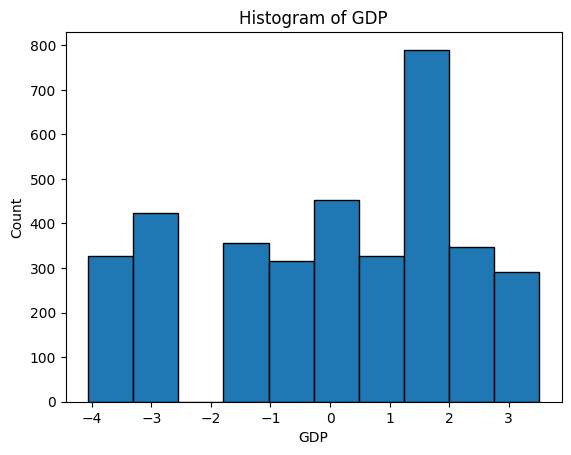

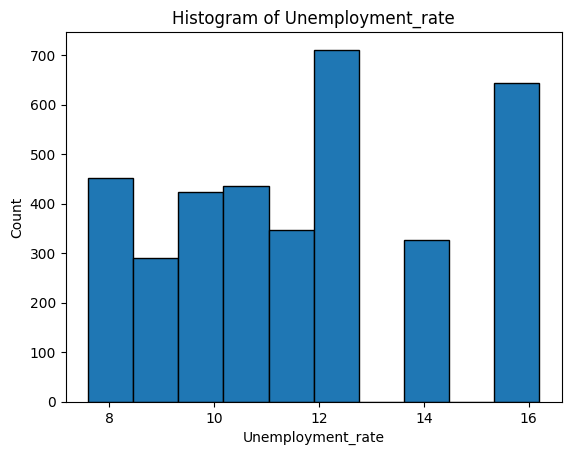

In [16]:
def create_hist(col):
    data = [val[col] for val in df.select(col).collect()]
    plt.hist(data, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

hist_cols = [
    'Previous_qualification_grade',
    'Admission_grade',
    'Inflation_rate',
    'GDP',
    'Unemployment_rate'
]

for i in hist_cols:
    create_hist(i)

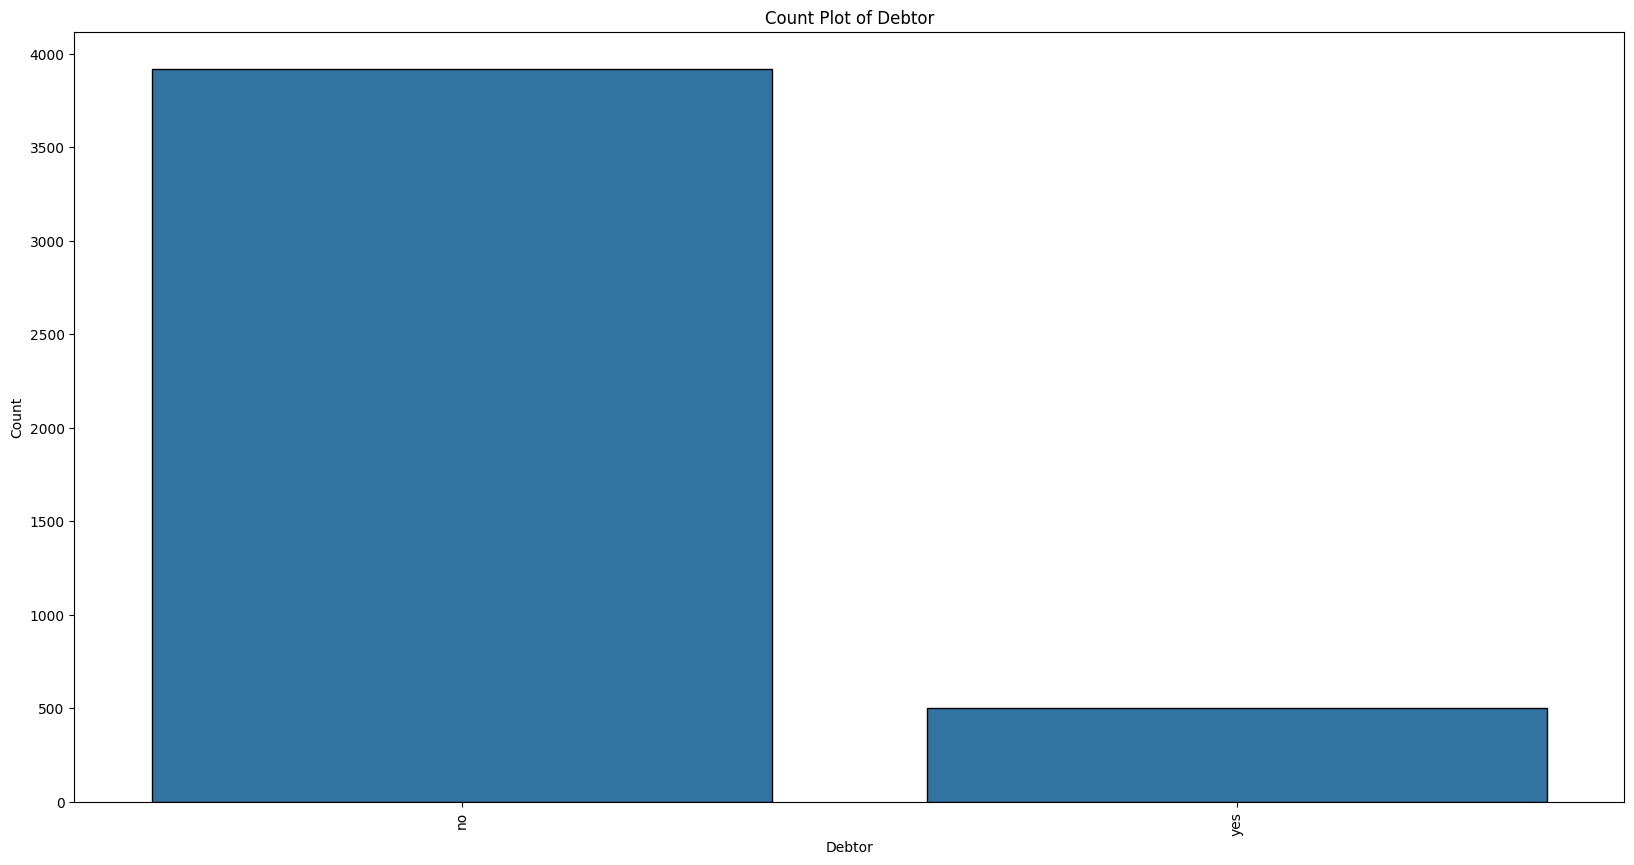

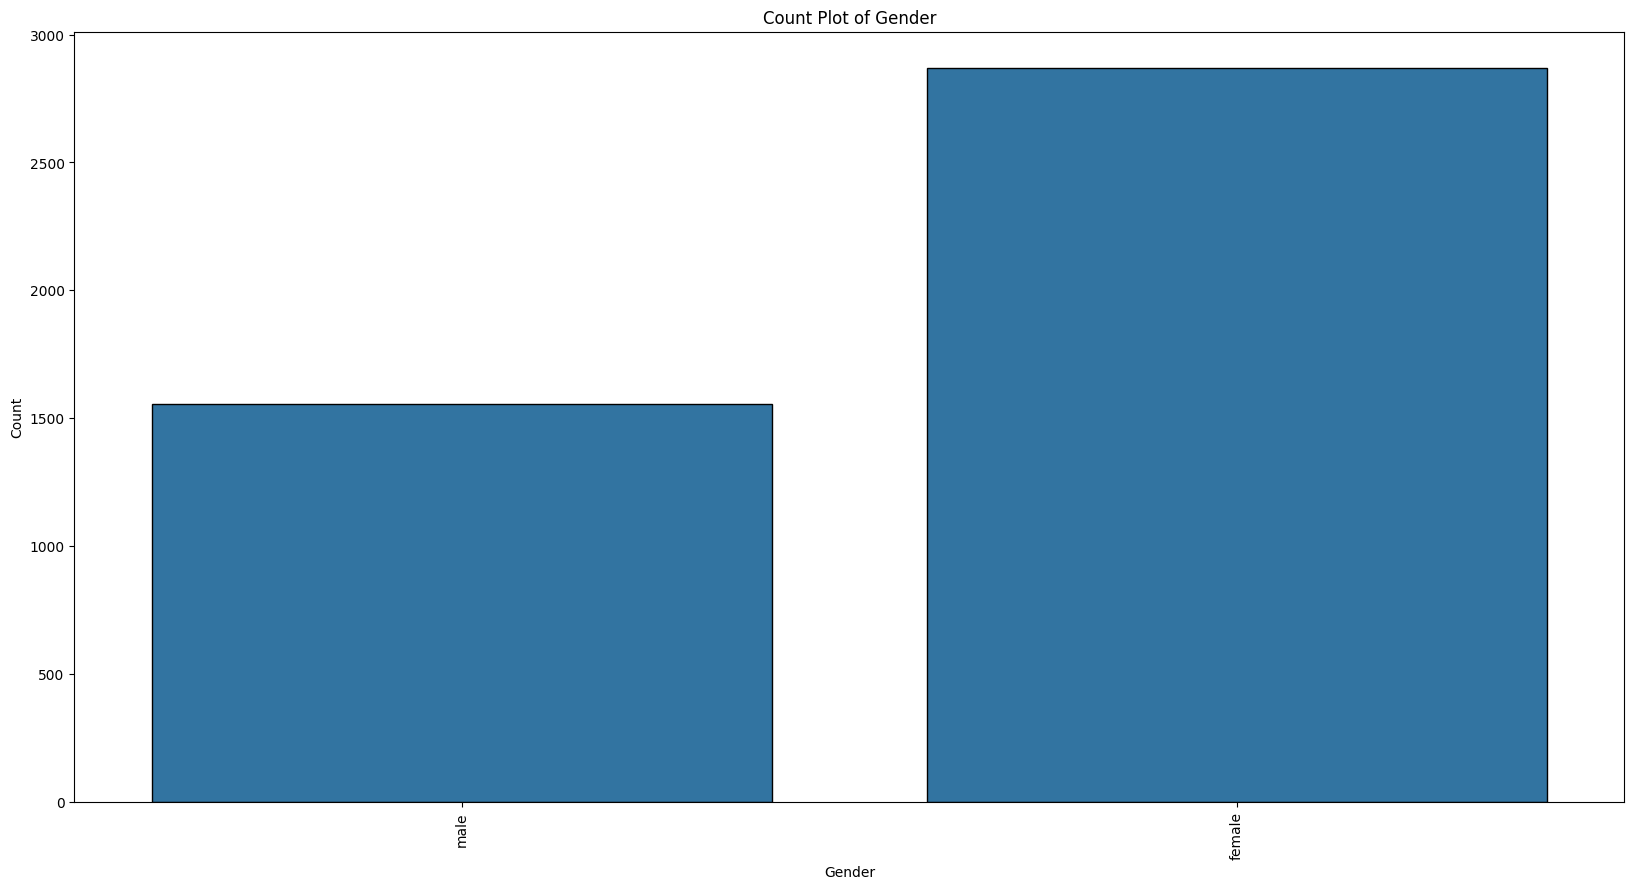

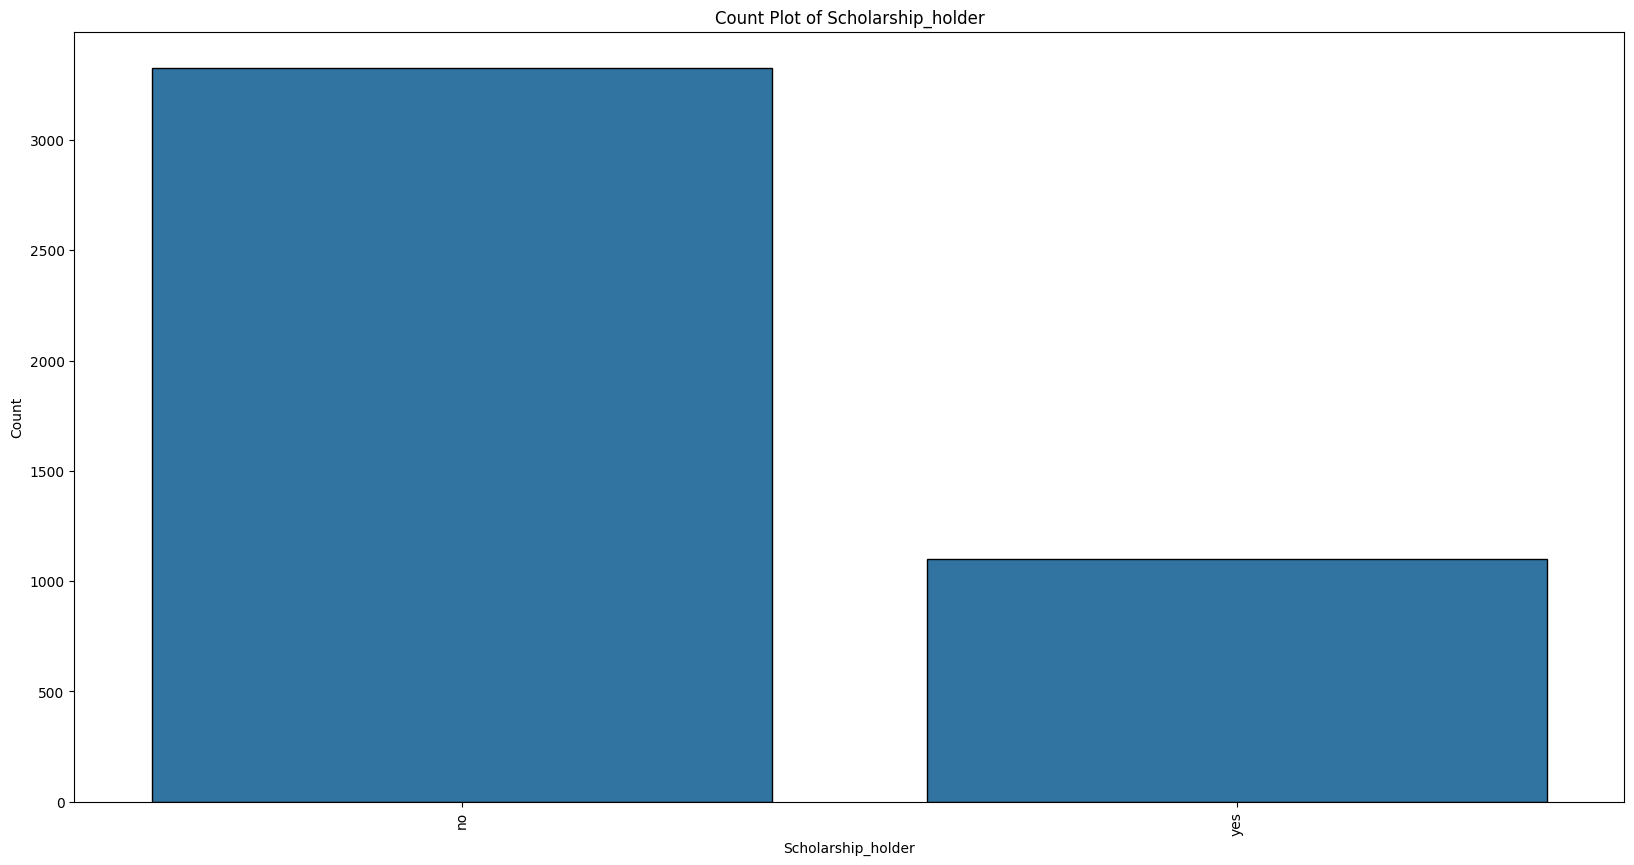

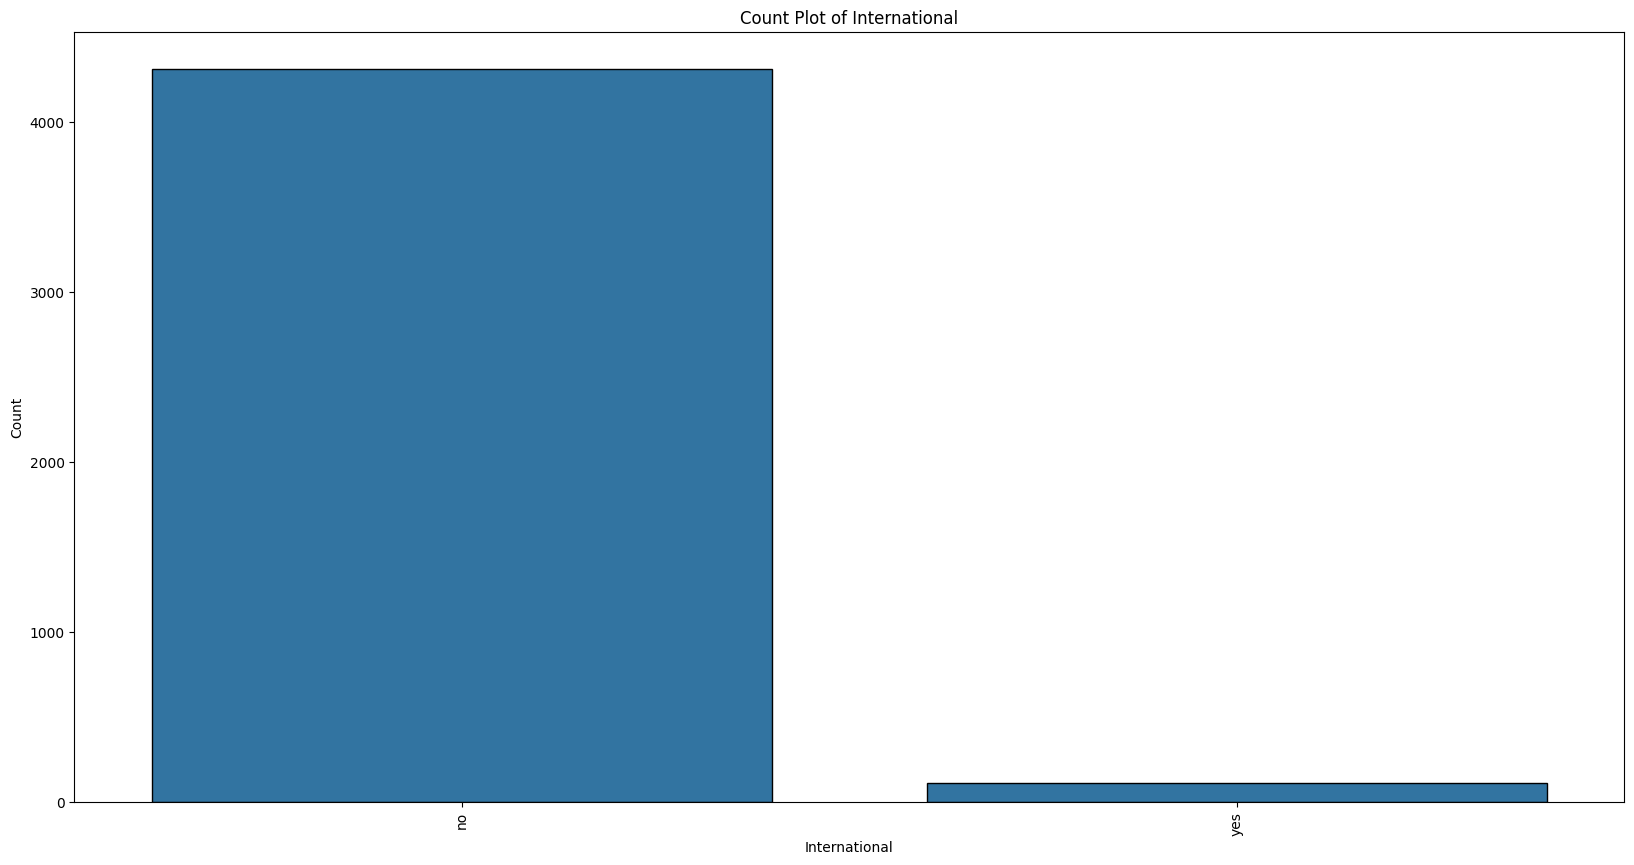

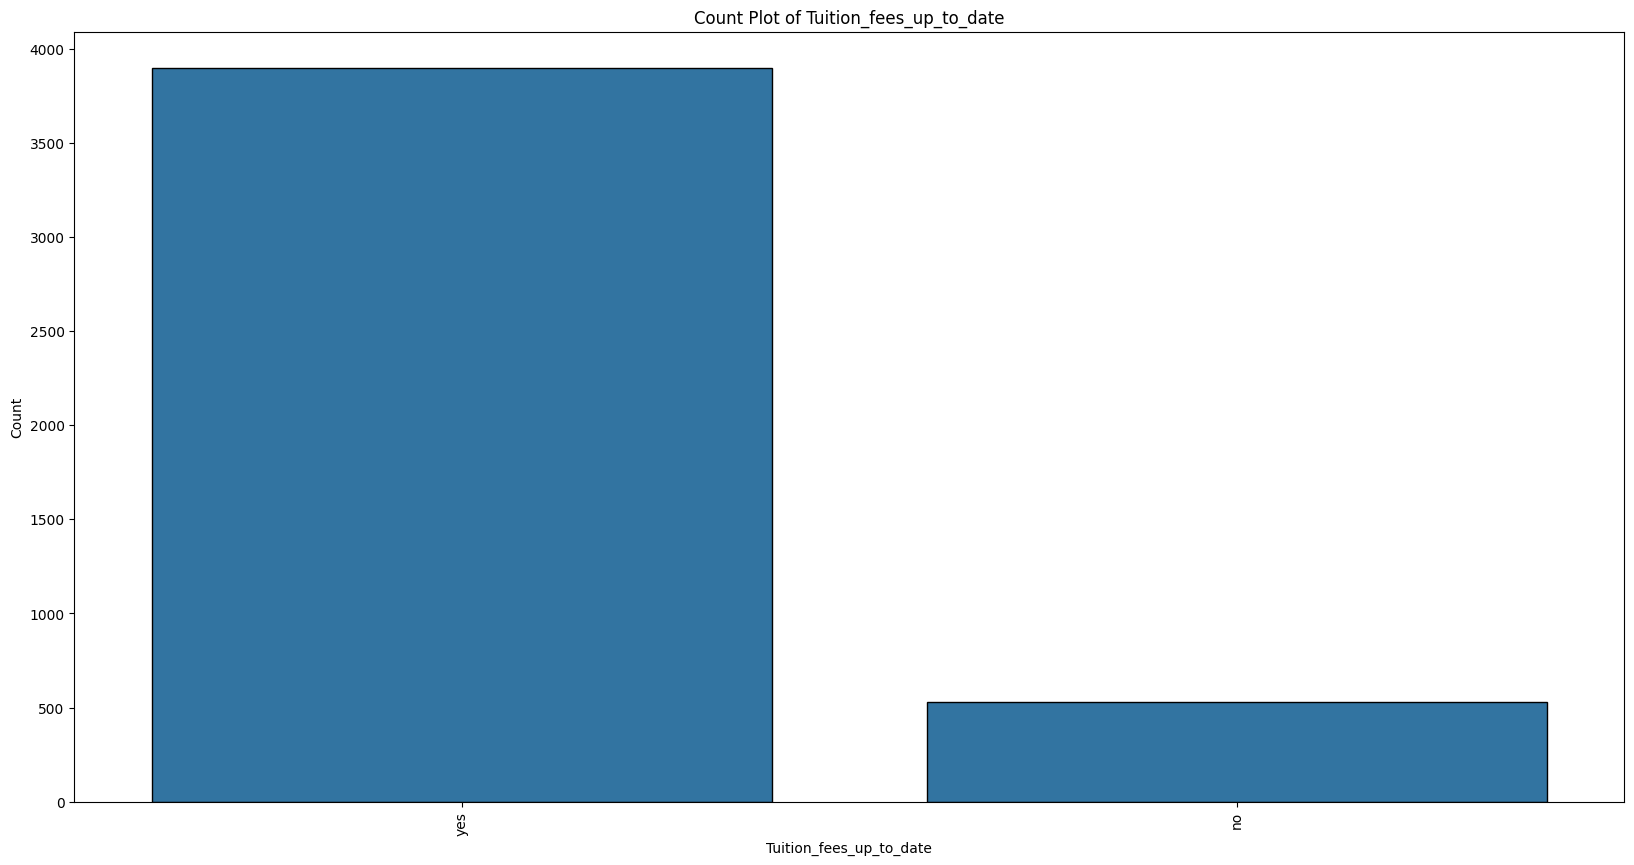

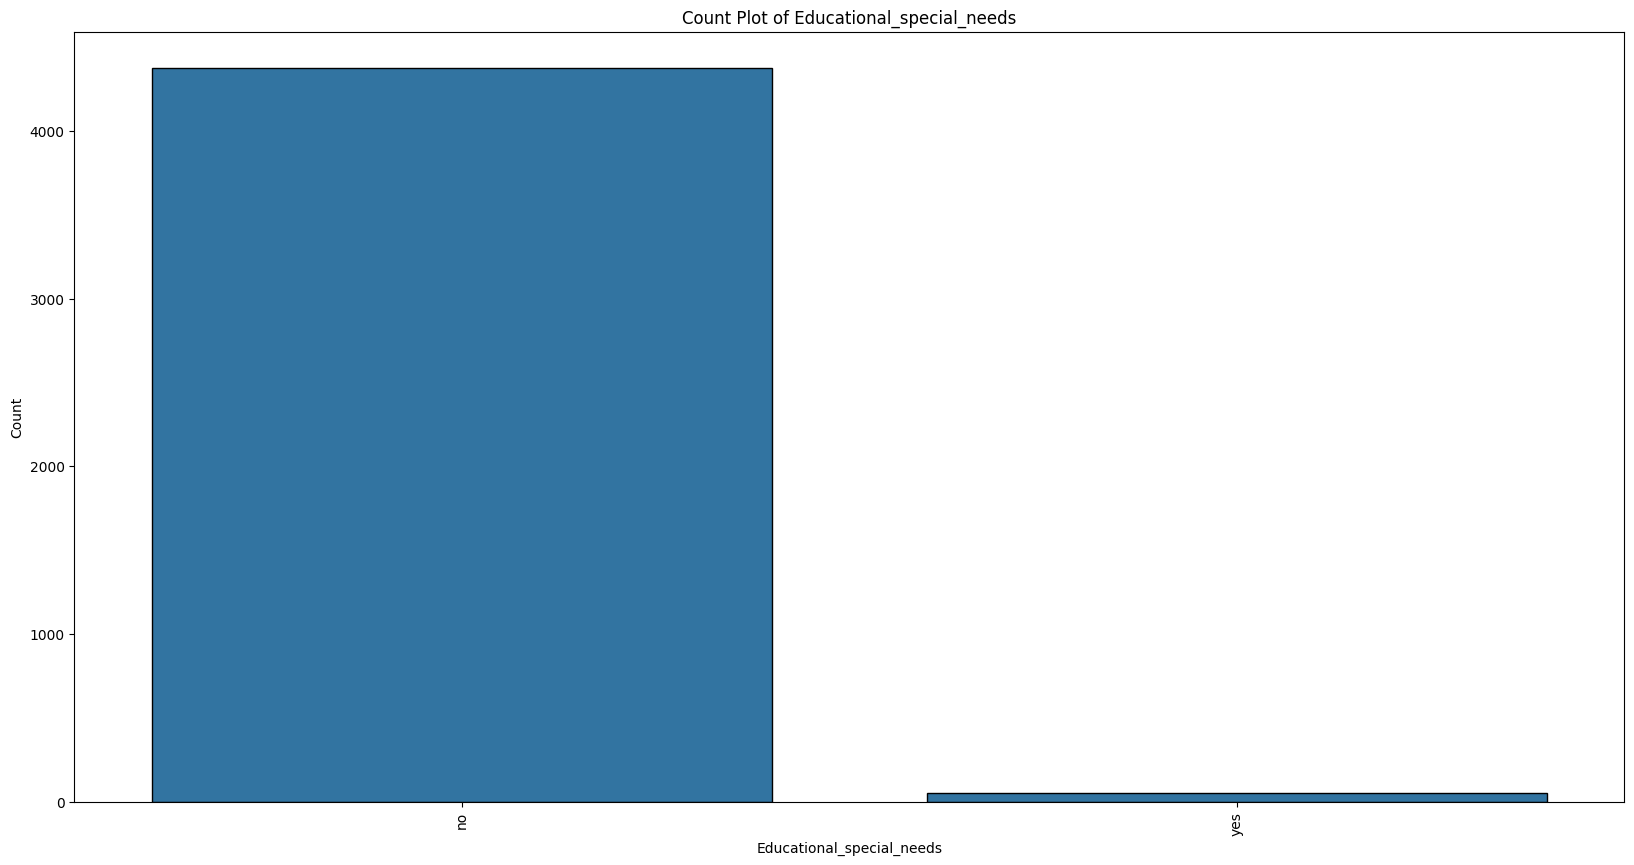

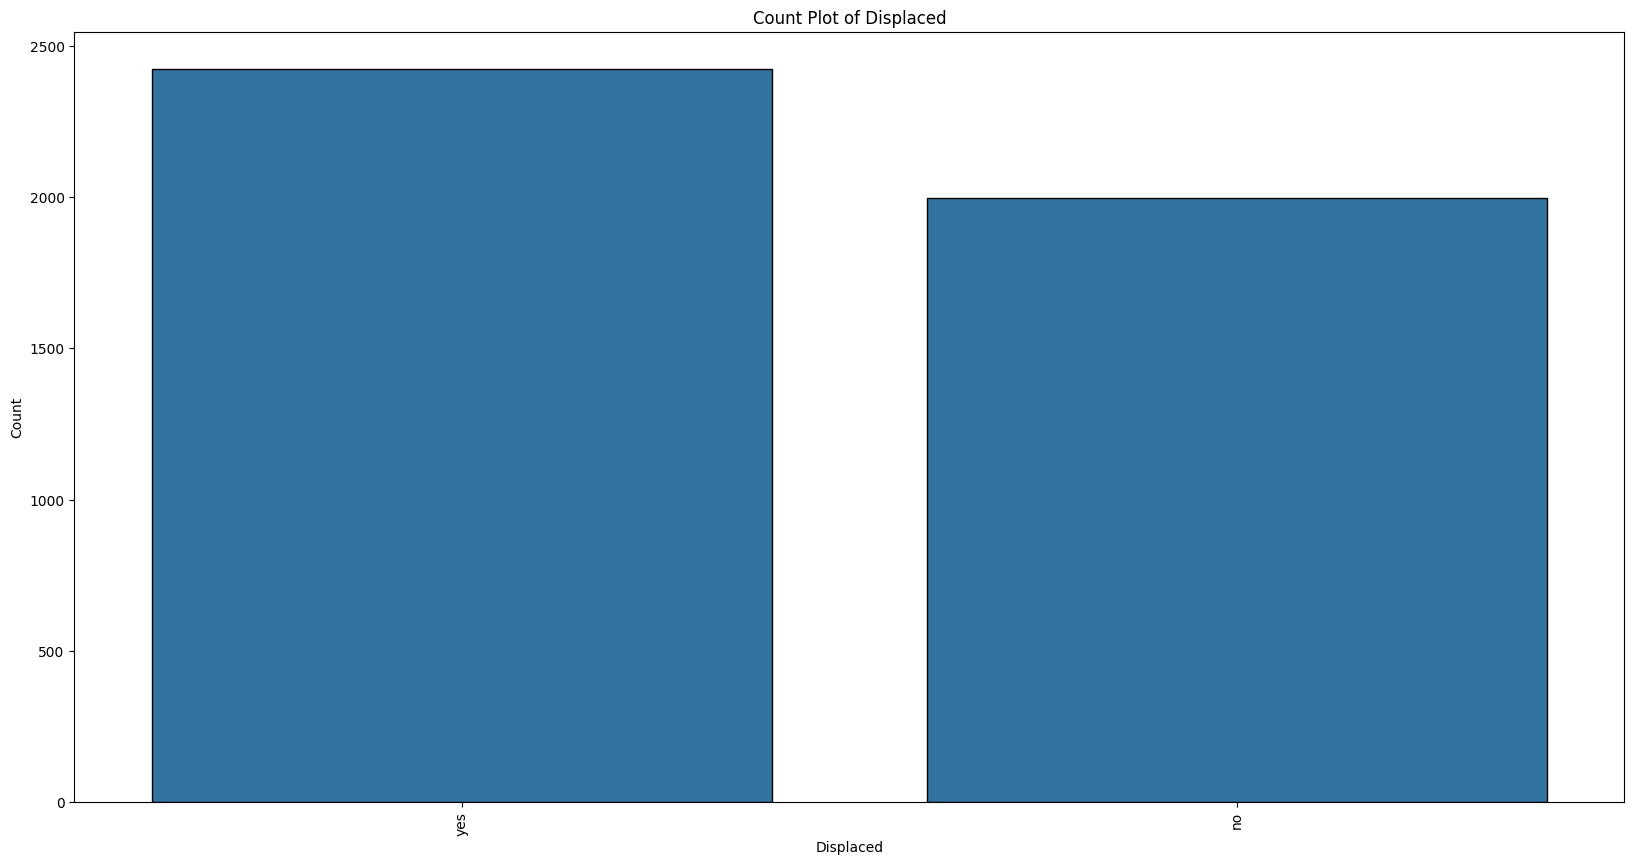

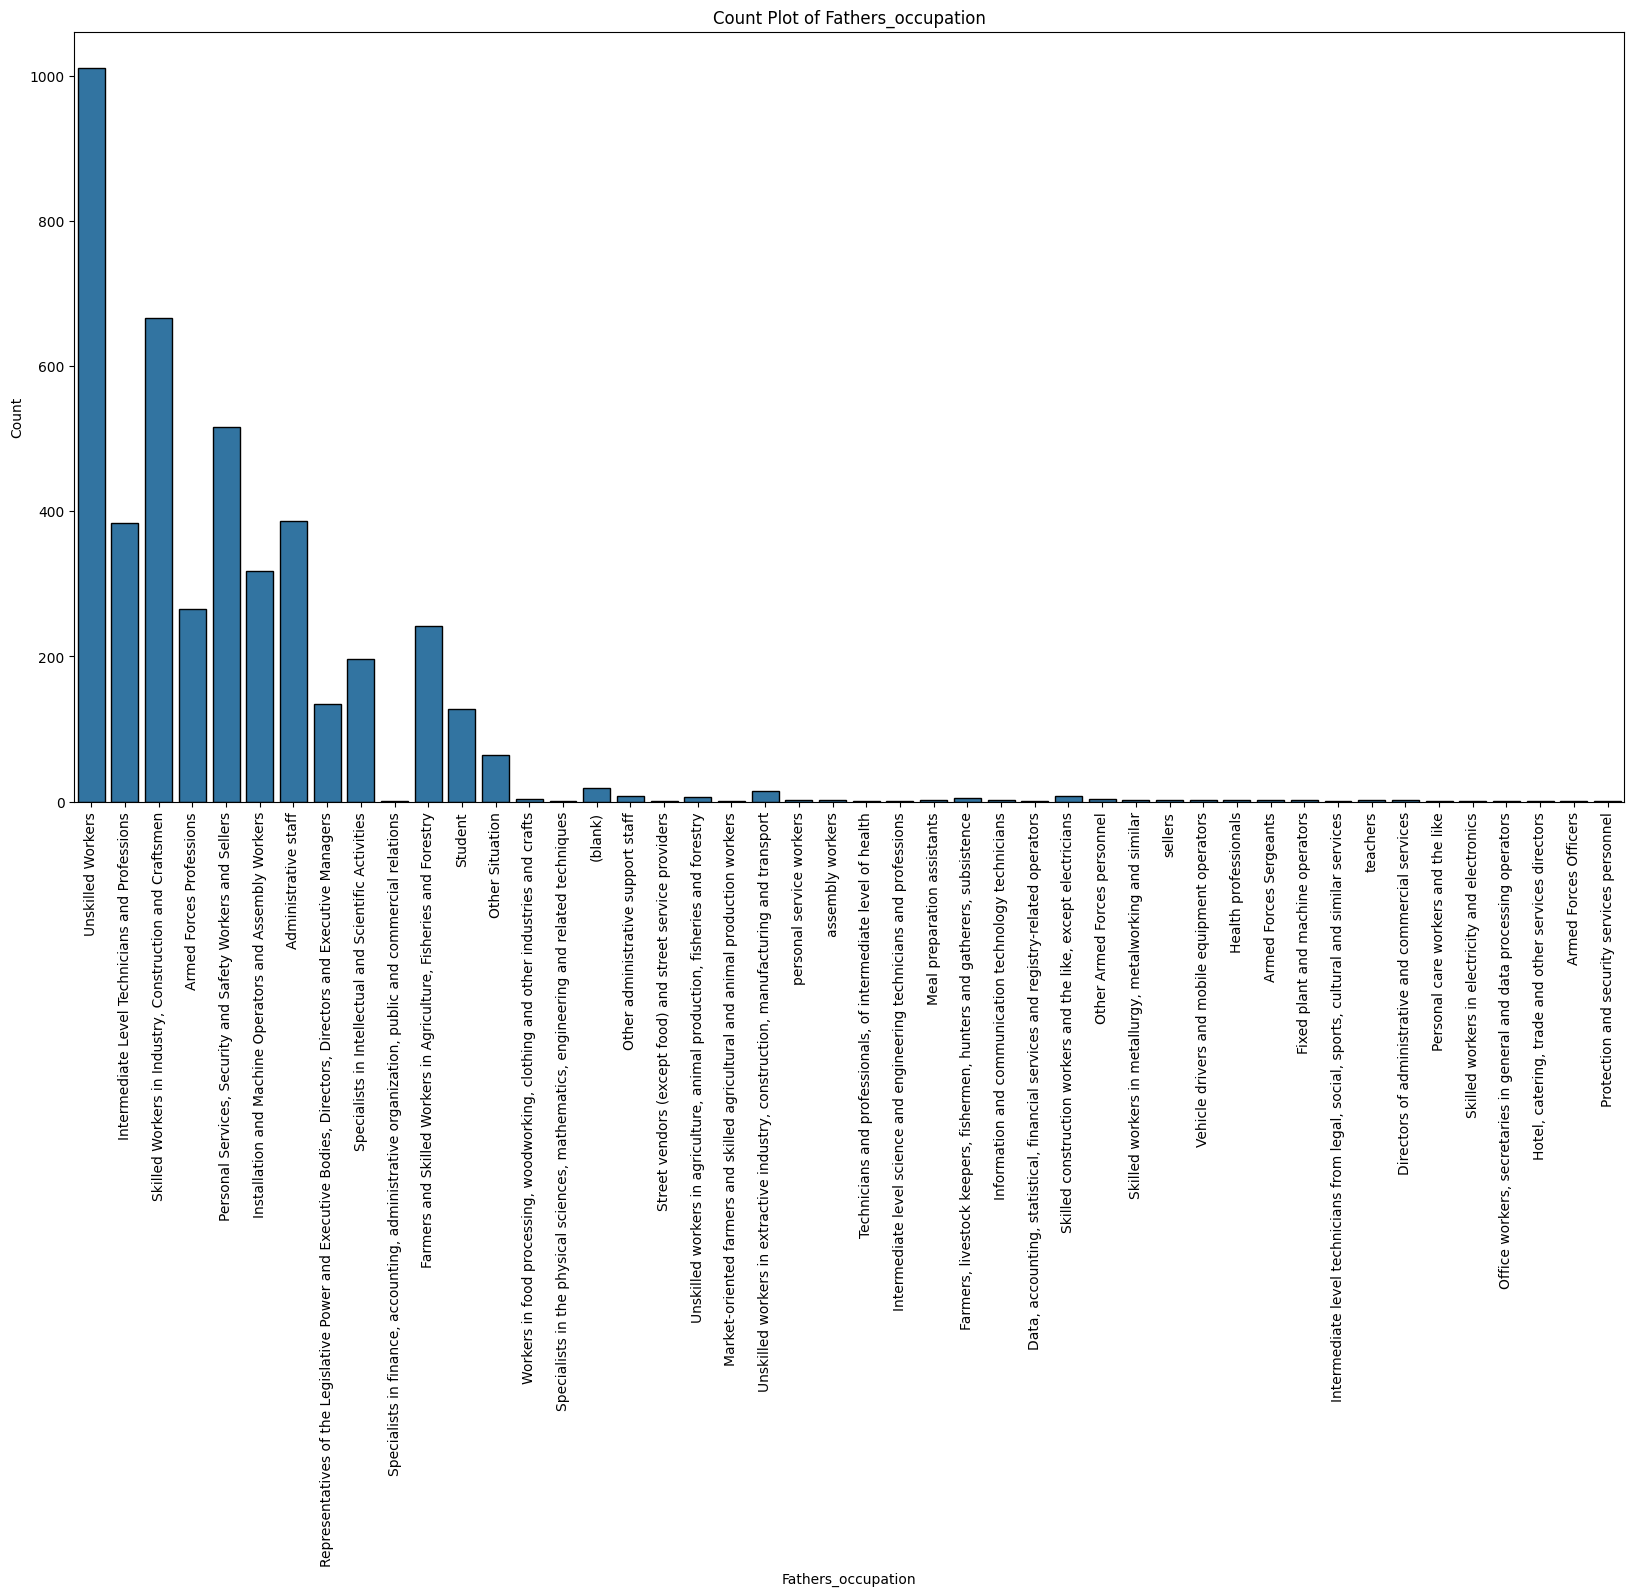

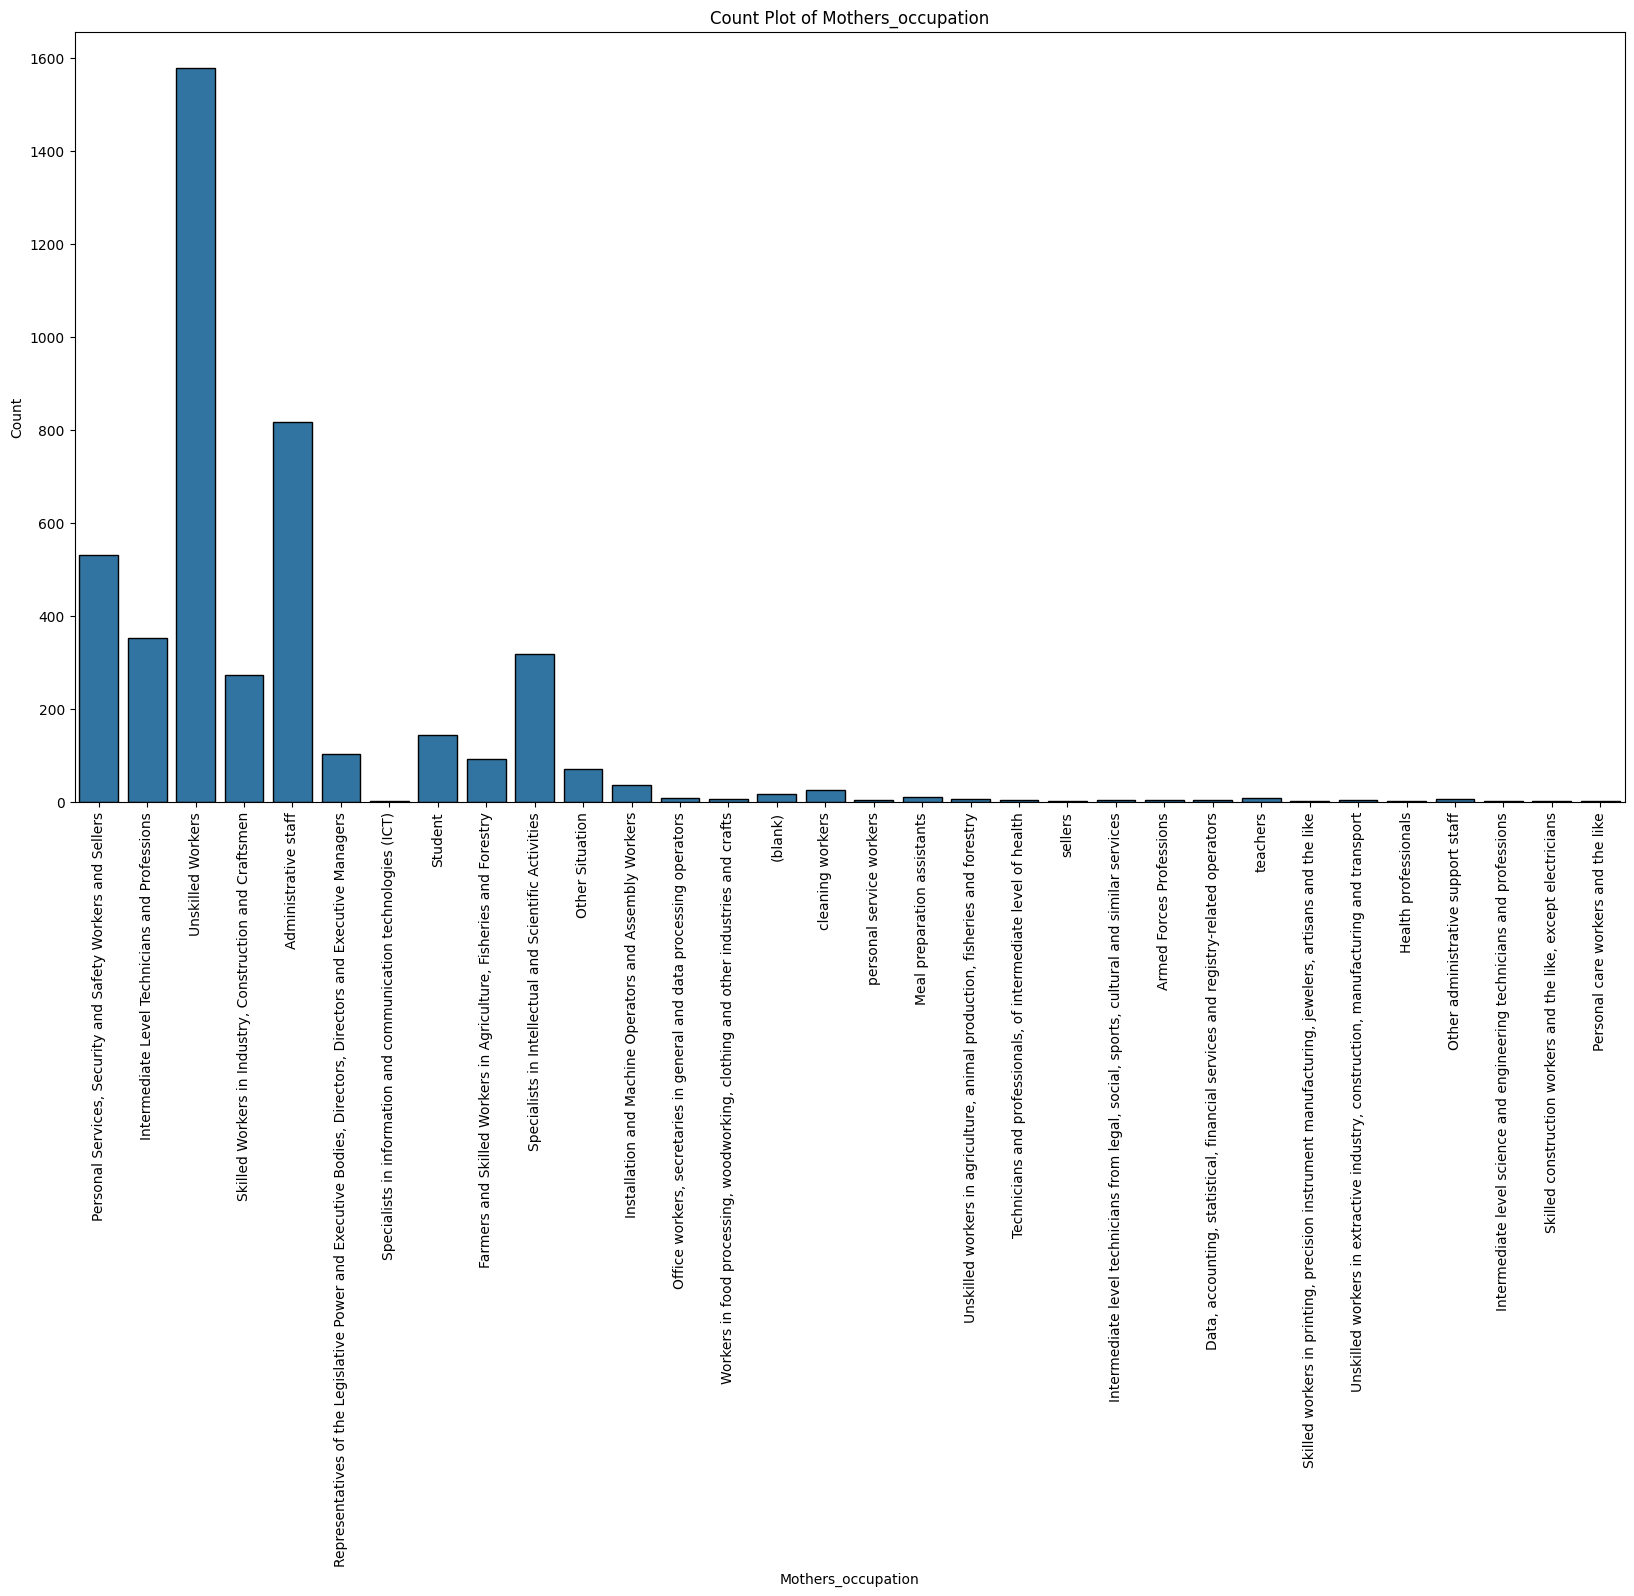

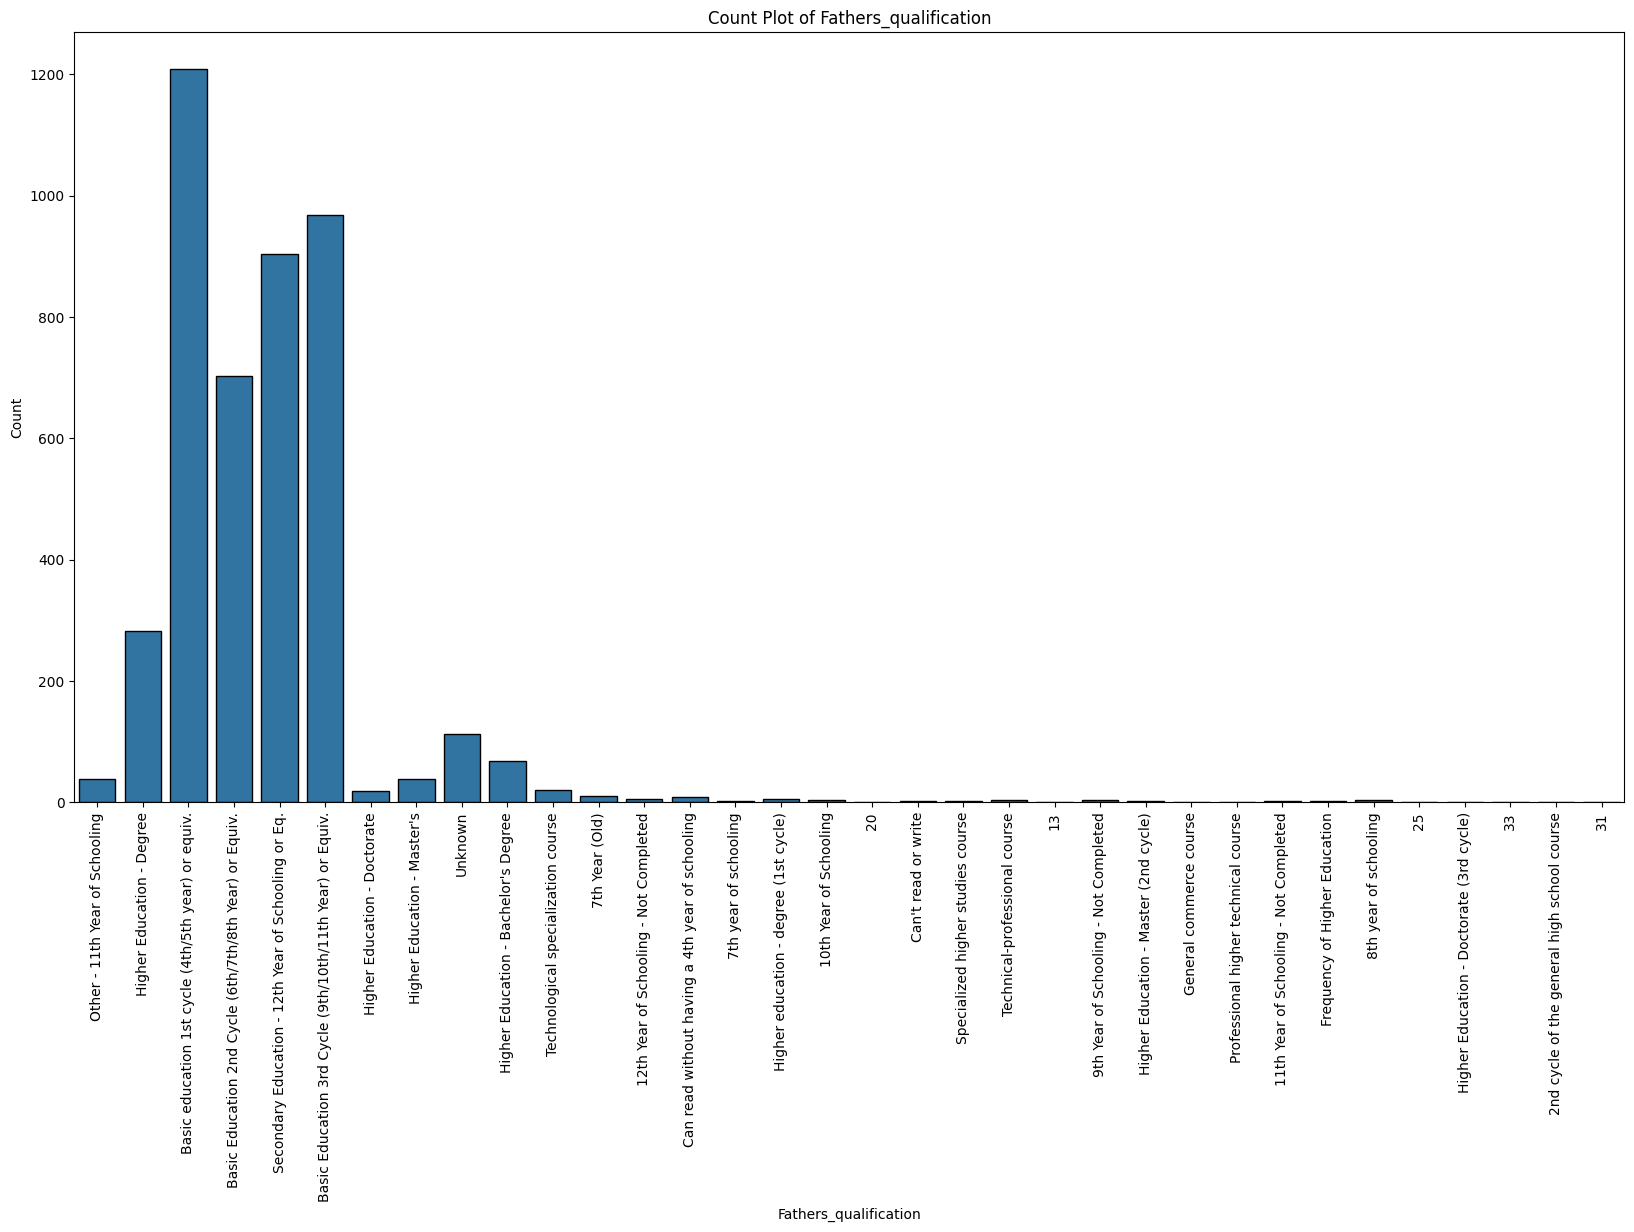

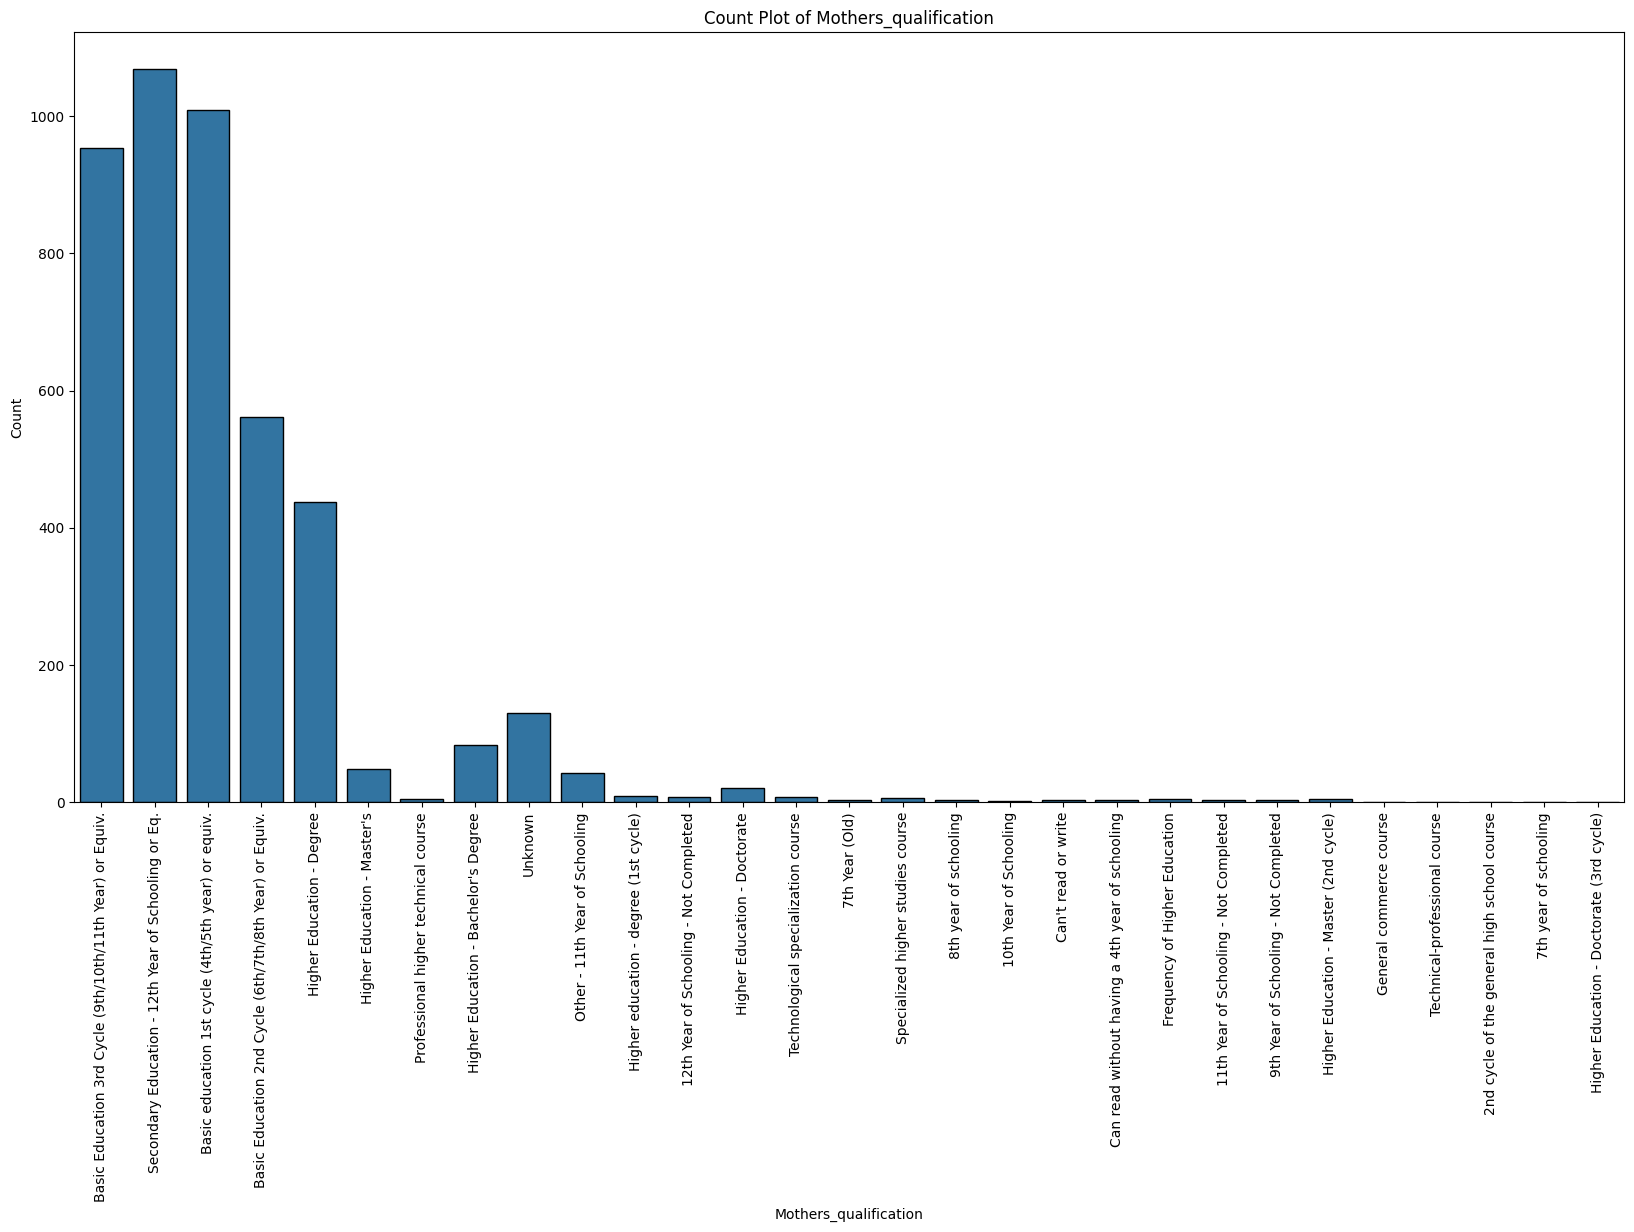

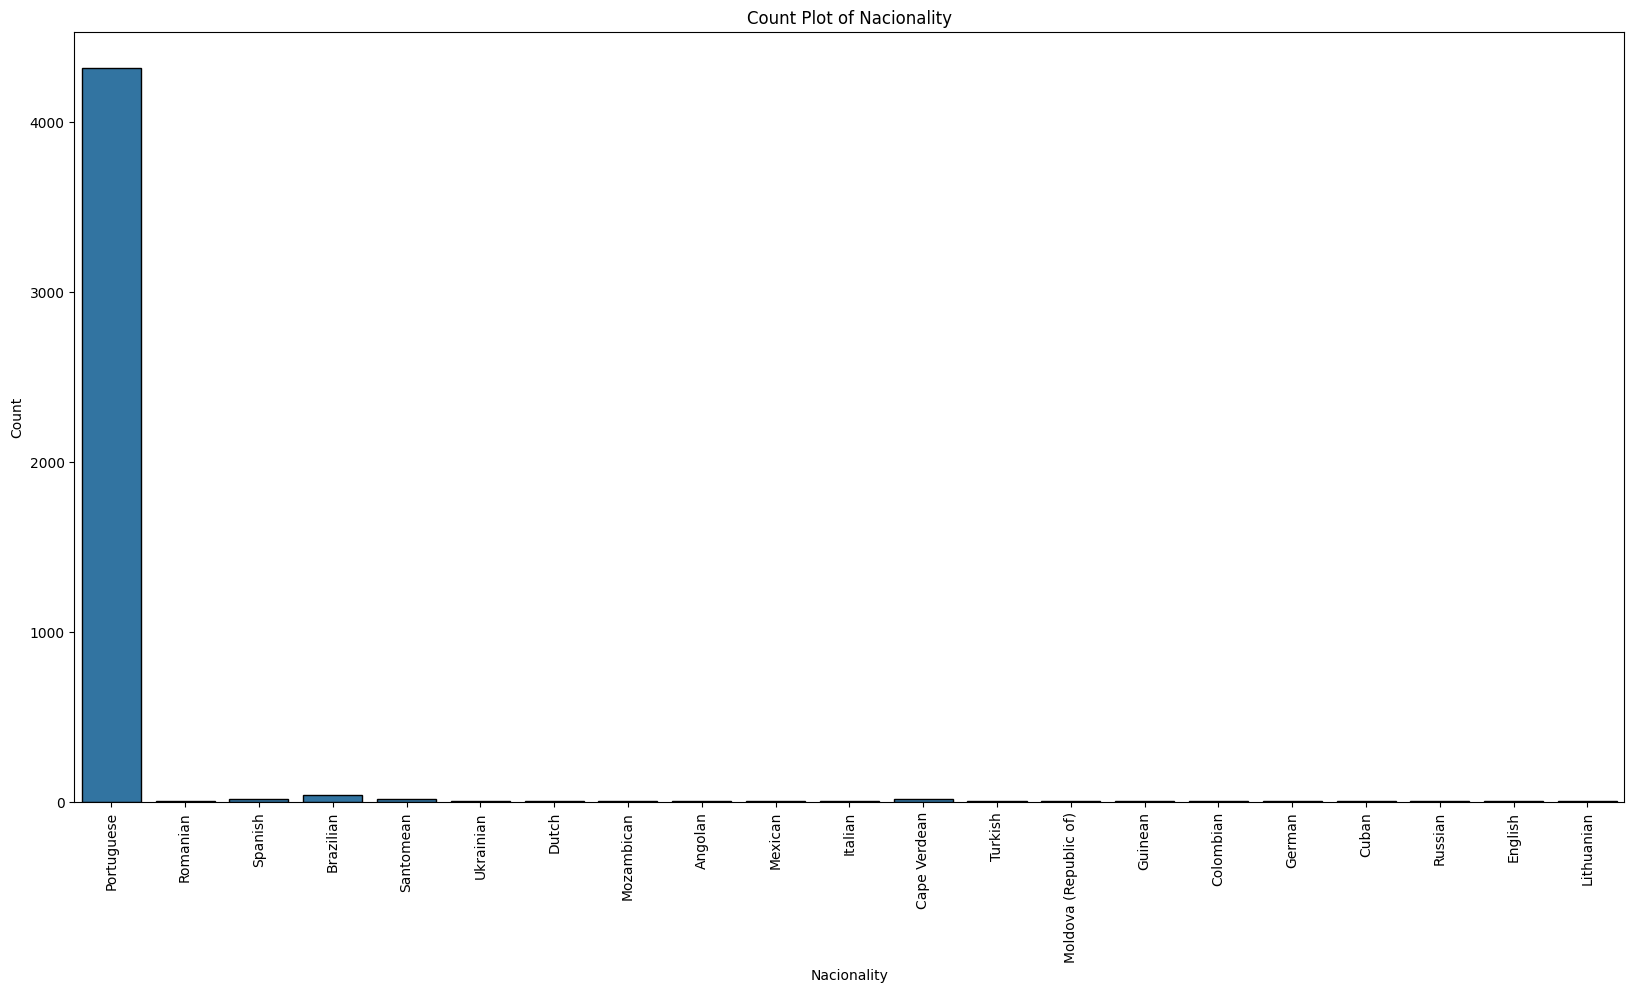

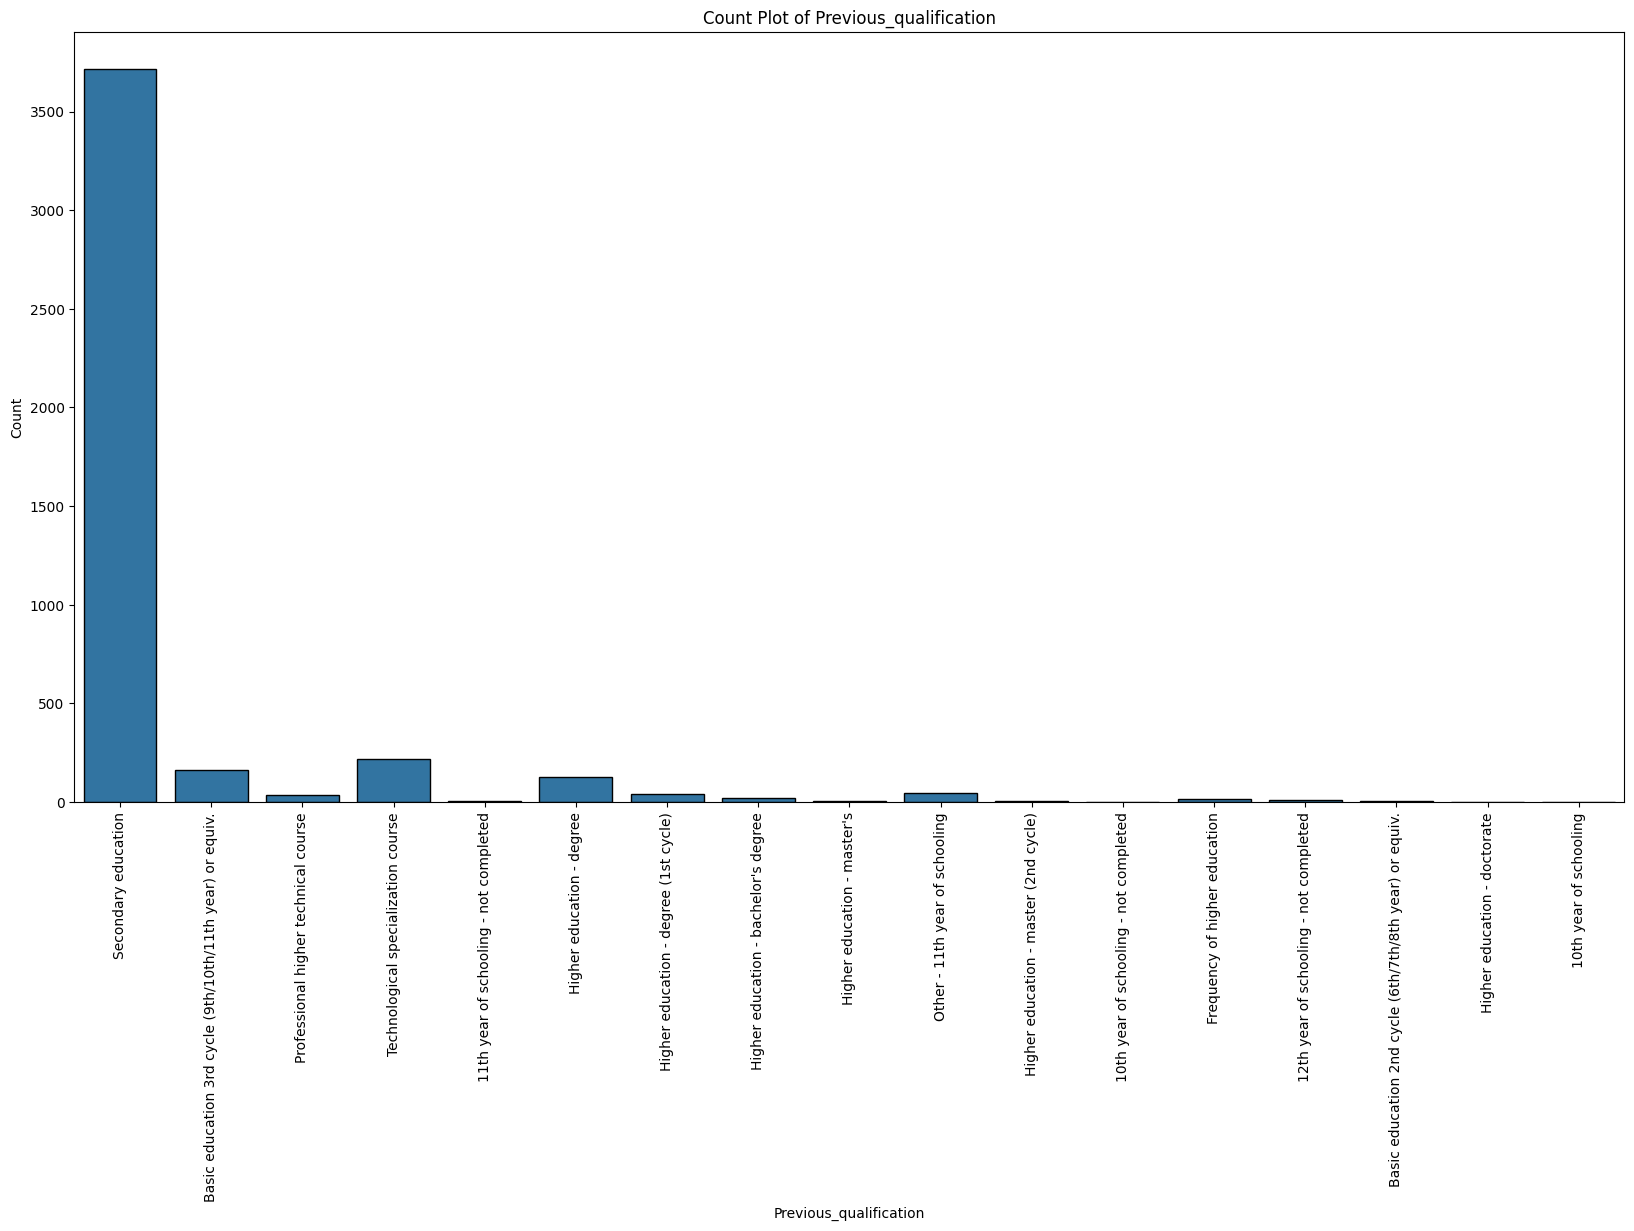

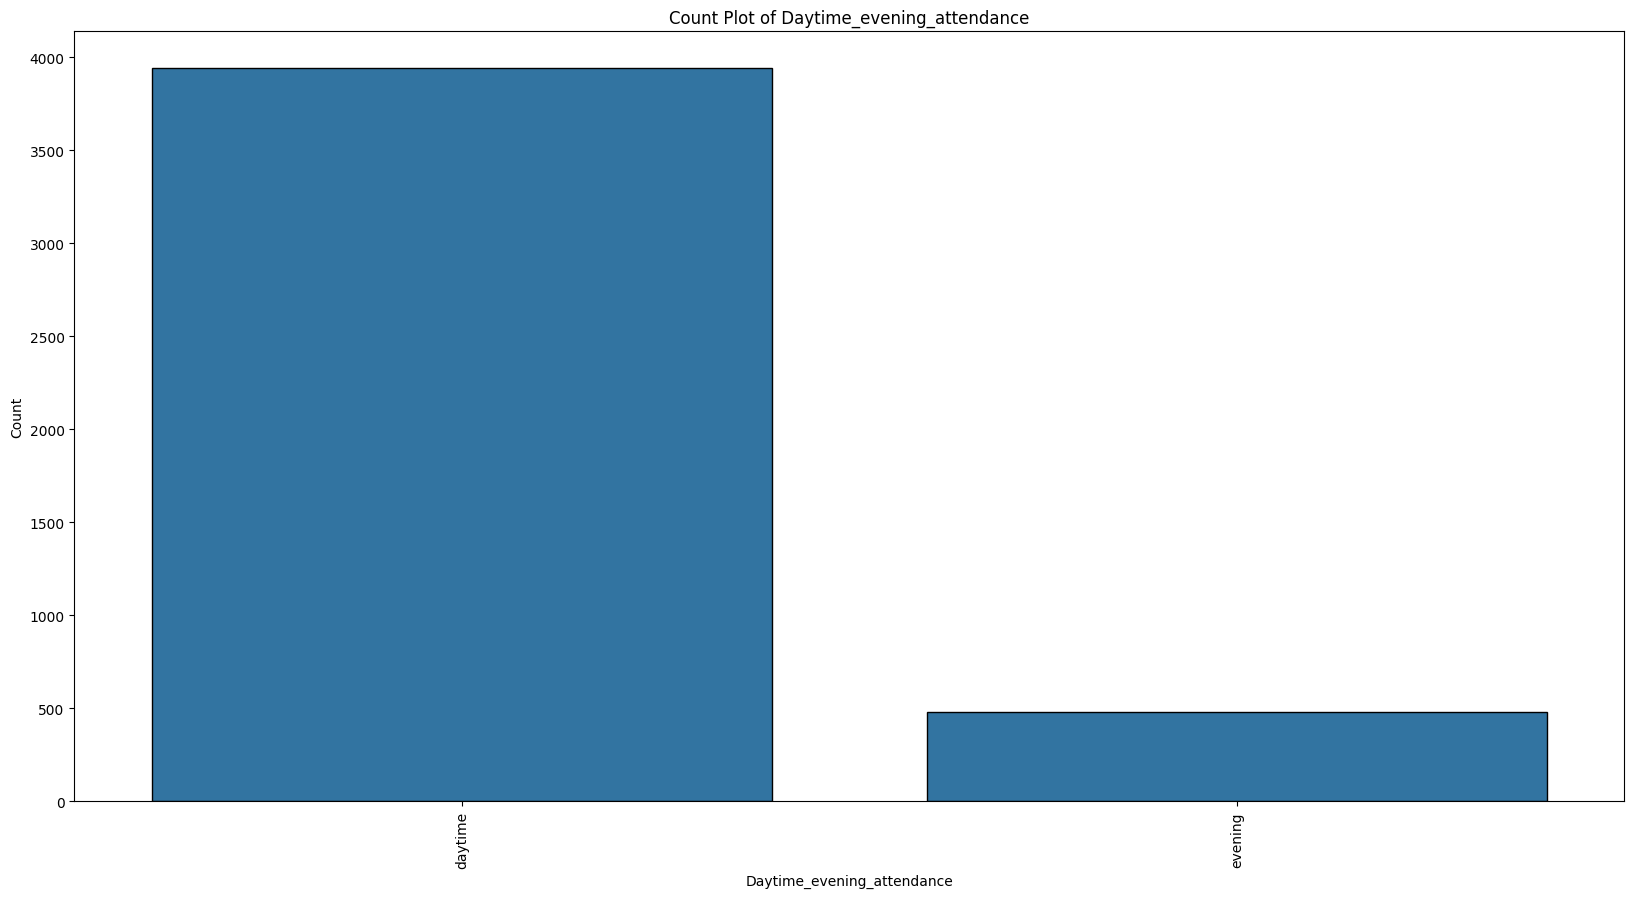

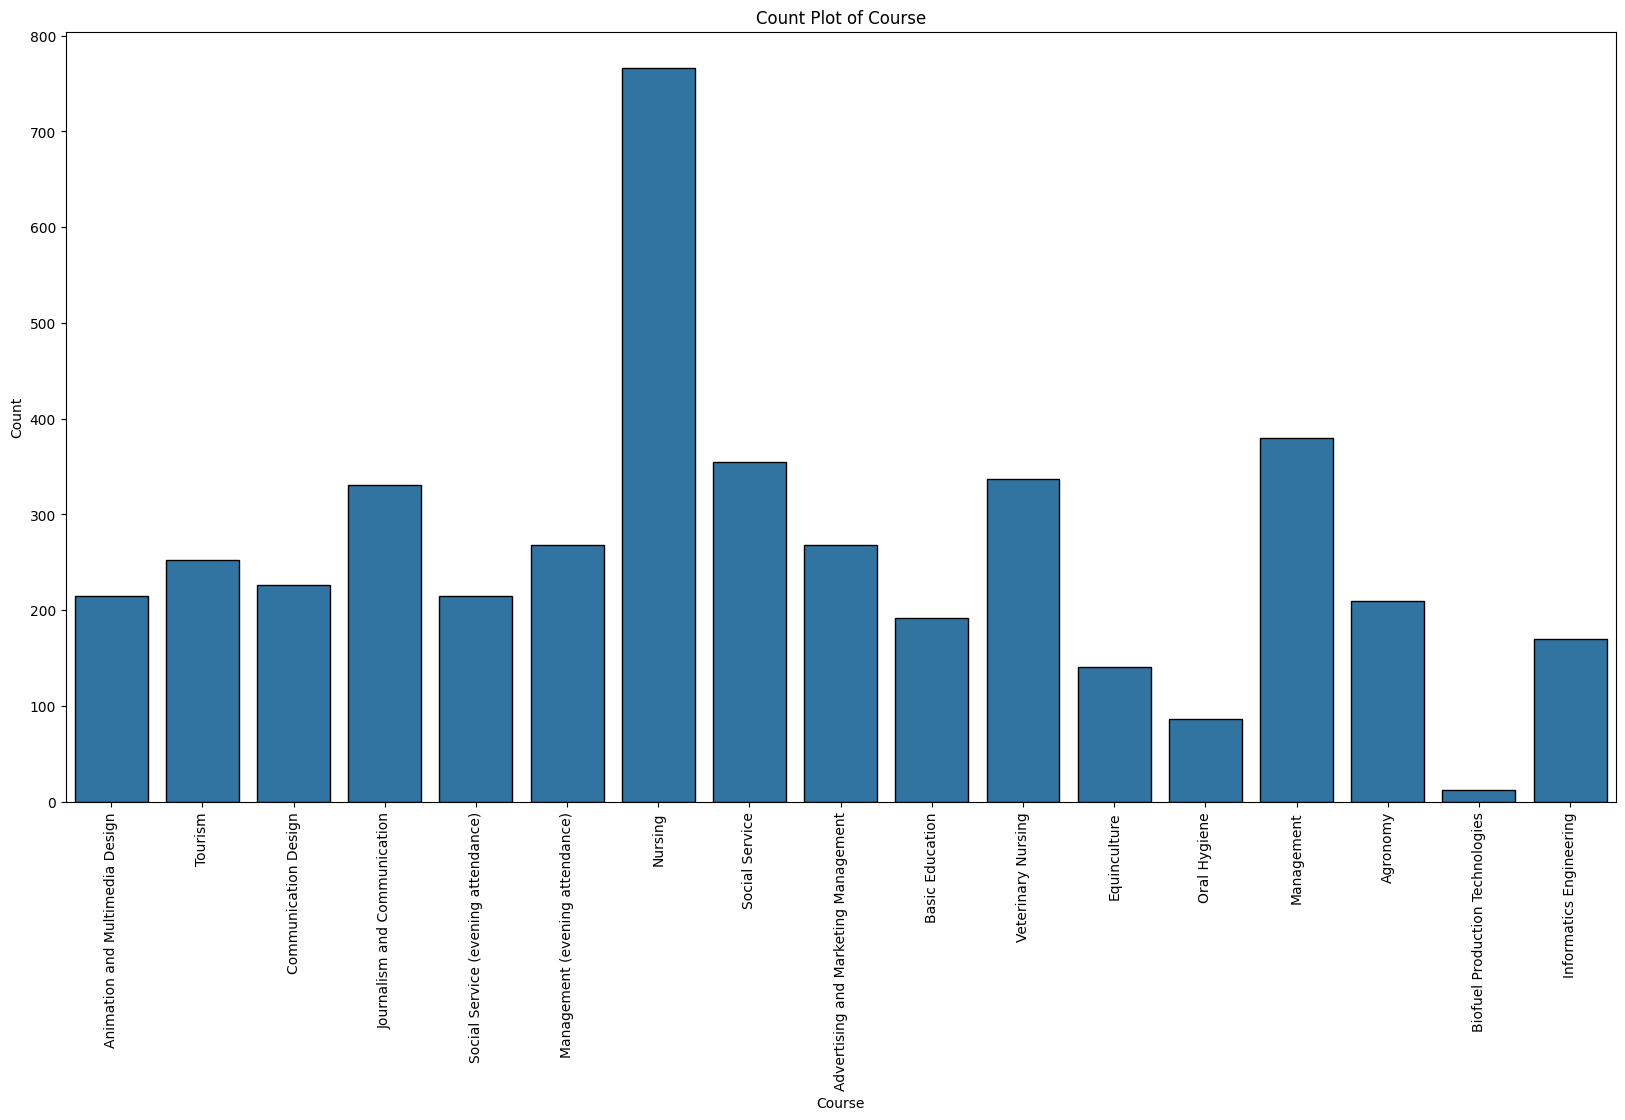

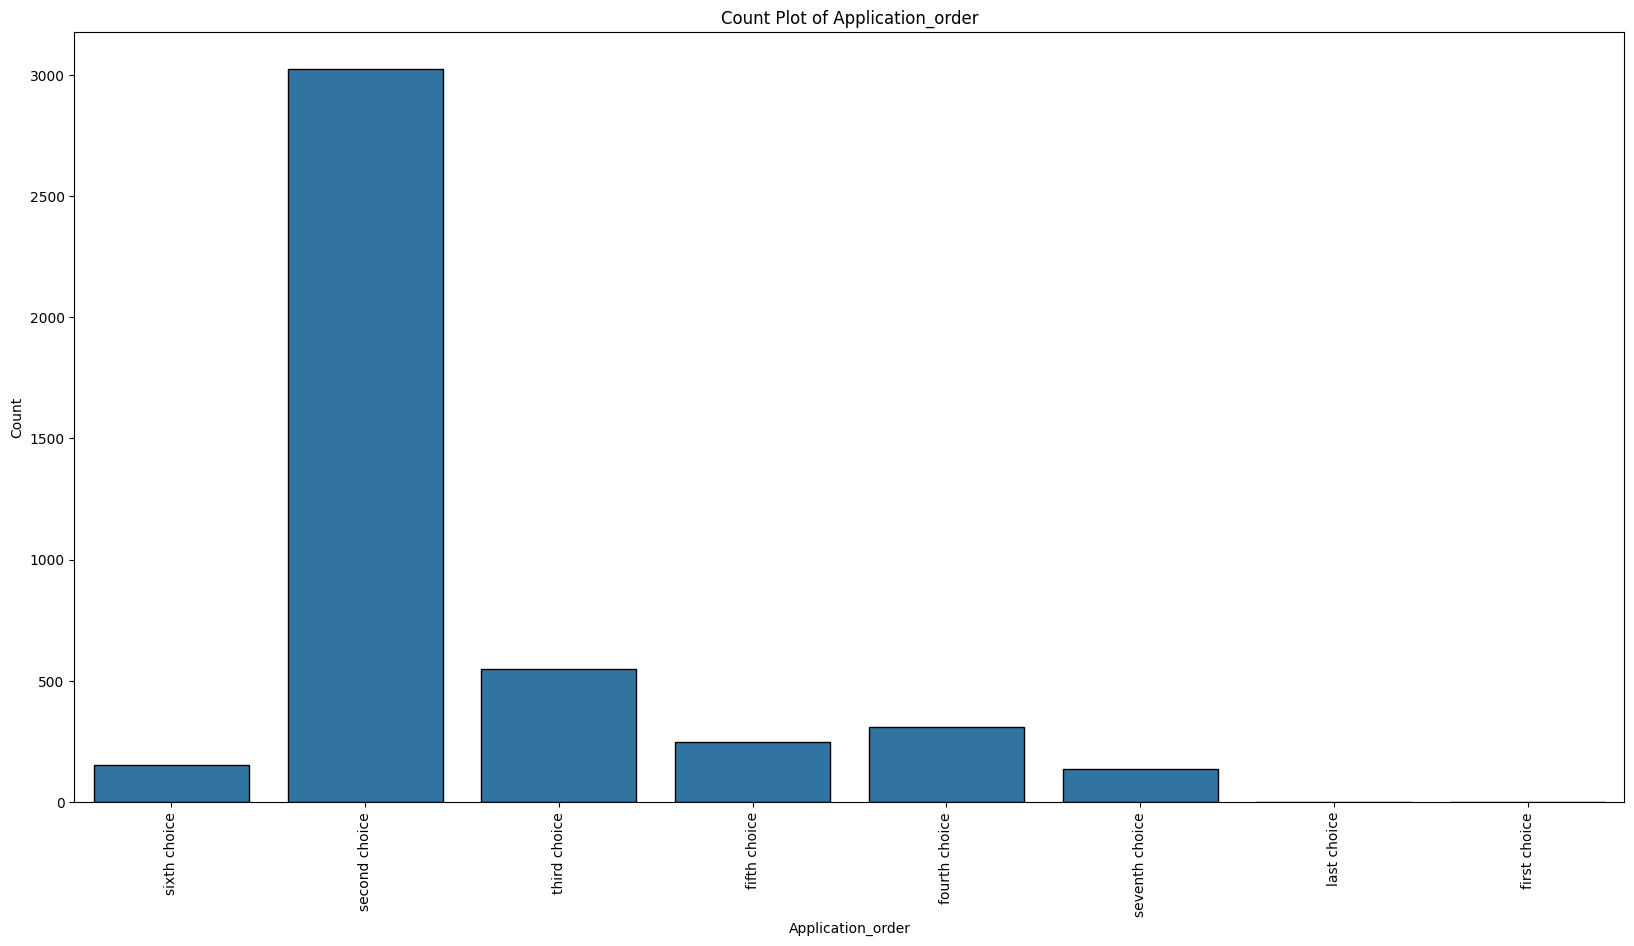

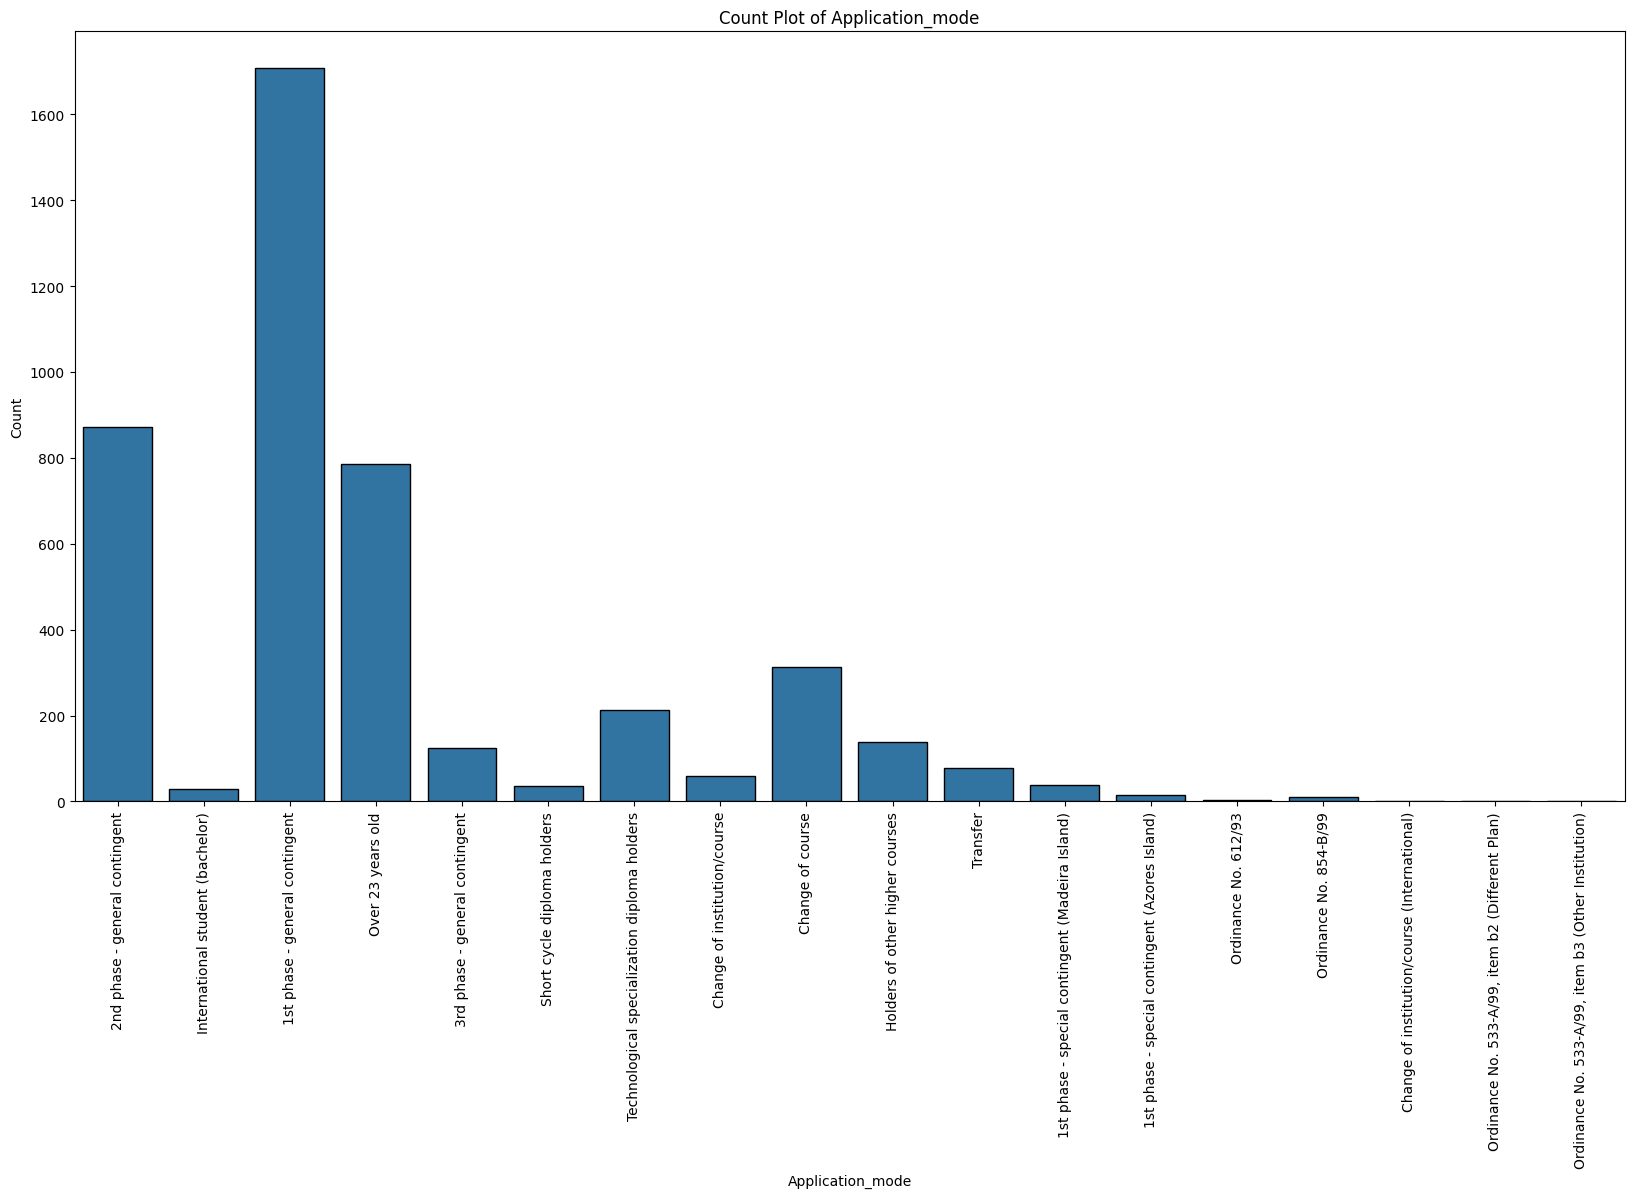

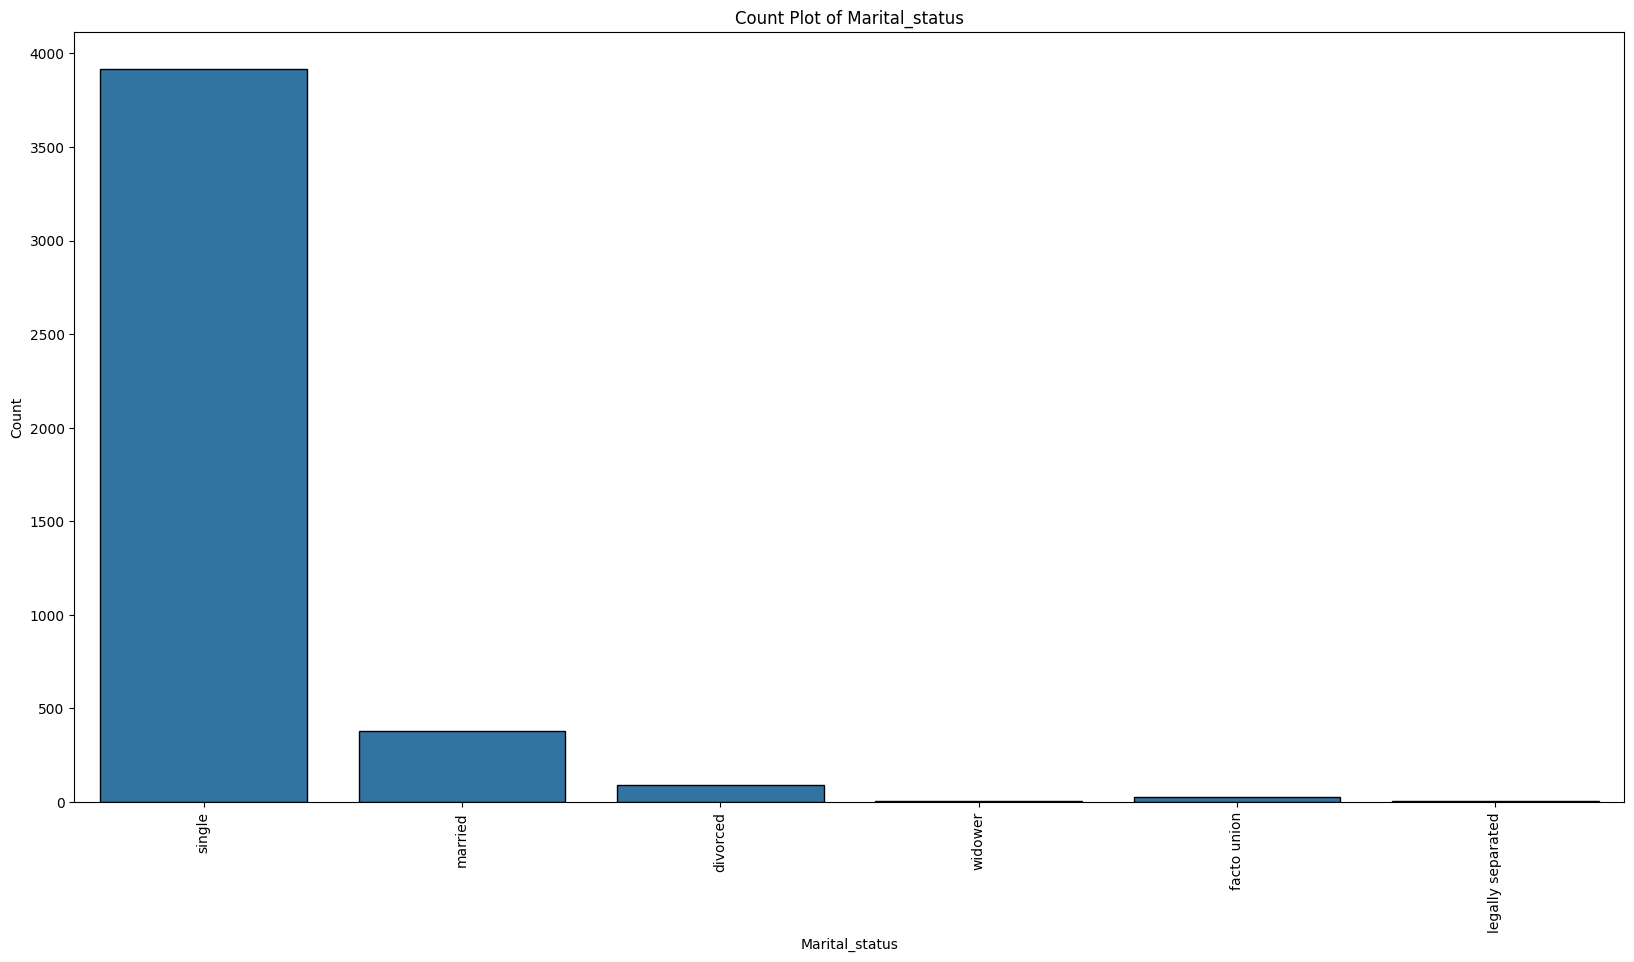

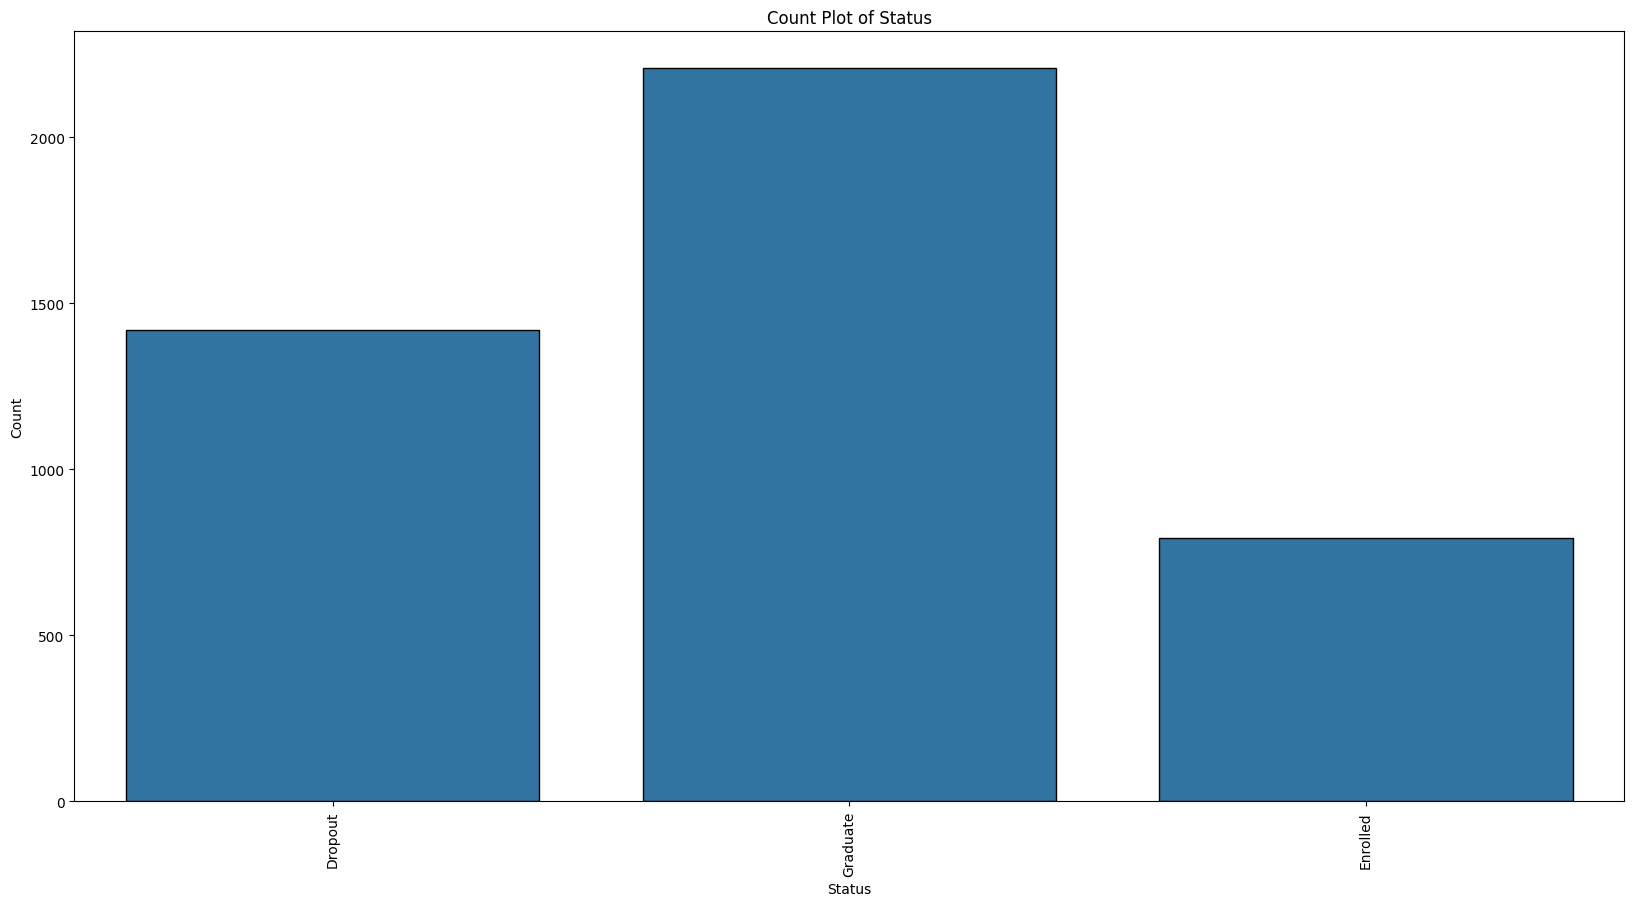

In [6]:
def create_count(col):
    data = [val[col] for val in new_df.select(col).collect()]
    plt.figure(figsize=(20,10))
    sns.countplot(x=data, edgecolor='black')
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

count_cols = [
    'Debtor',
    'Gender',
    'Scholarship_holder',
    'International',
    'Tuition_fees_up_to_date',
    'Educational_special_needs',
    'Displaced',
    'Fathers_occupation',
    'Mothers_occupation',
    'Fathers_qualification',
    'Mothers_qualification',
    'Nacionality',
    'Previous_qualification',
    'Daytime_evening_attendance',
    'Course',
    'Application_order',
    'Application_mode',
    'Marital_status',
    'Status'
]

for i in count_cols:
    create_count(i)

In [18]:
PWD = "2nl1rT49oYebFSgS"
USER_ID = "postgres.ykivpvnwtyzrlpizibhf"
DB = "postgres"
DRIVER = "org.postgresql.Driver"
SERVER_TARGET = "aws-0-ap-southeast-1.pooler.supabase.com"

target_url = f"jdbc:postgresql://{SERVER_TARGET}:6543/{DB}?user={USER_ID}&password={PWD}"

def load(df, table_name):
    try:
        print(f'Importing {df.count()} rows for table {table_name}')
        df.write.mode("overwrite") \
            .format("jdbc") \
            .option("url", target_url) \
            .option("user", USER_ID) \
            .option("password", PWD) \
            .option("driver", DRIVER) \
            .option("dbtable", table_name) \
            .save()
        print("Data imported successfully")
        
    except Exception as e:
        print("Data load error: " + str(e))

load(df=new_df, table_name='data')

Importing 3630 rows for table data
Data imported successfully


## Data Preparation / Preprocessing

In [19]:
assembler1 = VectorAssembler().setInputCols(['Previous_qualification_grade']).setOutputCol('vec_Previous_qualification_grade')
assembler2 = VectorAssembler().setInputCols(['Admission_grade']).setOutputCol('vec_Admission_grade')
assembler3 = VectorAssembler().setInputCols(['Unemployment_rate']).setOutputCol('vec_Unemployment_rate')
assembler4 = VectorAssembler().setInputCols(['Inflation_rate']).setOutputCol('vec_Inflation_rate')
assembler5 = VectorAssembler().setInputCols(['GDP']).setOutputCol('vec_GDP')
assembler6 = VectorAssembler().setInputCols(['Age_at_enrollment']).setOutputCol('vec_Age_at_enrollment')
assembler7 = VectorAssembler().setInputCols(['Curricular_units_1st_sem_credited']).setOutputCol('vec_Curricular_units_1st_sem_credited')
assembler8 = VectorAssembler().setInputCols(['Curricular_units_1st_sem_enrolled']).setOutputCol('vec_Curricular_units_1st_sem_enrolled')
assembler9 = VectorAssembler().setInputCols(['Curricular_units_1st_sem_evaluations']).setOutputCol('vec_Curricular_units_1st_sem_evaluations')
assembler10 = VectorAssembler().setInputCols(['Curricular_units_1st_sem_approved']).setOutputCol('vec_Curricular_units_1st_sem_approved')
assembler11 = VectorAssembler().setInputCols(['Curricular_units_1st_sem_grade']).setOutputCol('vec_Curricular_units_1st_sem_grade')
assembler12 = VectorAssembler().setInputCols(['Curricular_units_1st_sem_without_evaluations']).setOutputCol('vec_Curricular_units_1st_sem_without_evaluations')
assembler13 = VectorAssembler().setInputCols(['Curricular_units_2nd_sem_credited']).setOutputCol('vec_Curricular_units_2nd_sem_credited')
assembler14 = VectorAssembler().setInputCols(['Curricular_units_2nd_sem_enrolled']).setOutputCol('vec_Curricular_units_2nd_sem_enrolled')
assembler15 = VectorAssembler().setInputCols(['Curricular_units_2nd_sem_evaluations']).setOutputCol('vec_Curricular_units_2nd_sem_evaluations')
assembler16 = VectorAssembler().setInputCols(['Curricular_units_2nd_sem_approved']).setOutputCol('vec_Curricular_units_2nd_sem_approved')
assembler17 = VectorAssembler().setInputCols(['Curricular_units_2nd_sem_grade']).setOutputCol('vec_Curricular_units_2nd_sem_grade')
assembler18 = VectorAssembler().setInputCols(['Curricular_units_2nd_sem_without_evaluations']).setOutputCol('vec_Curricular_units_2nd_sem_without_evaluations')

df = assembler1.transform(df)
df = assembler2.transform(df)
df = assembler3.transform(df)
df = assembler4.transform(df)
df = assembler5.transform(df)
df = assembler6.transform(df)
df = assembler7.transform(df)
df = assembler8.transform(df)
df = assembler9.transform(df)
df = assembler10.transform(df)
df = assembler11.transform(df)
df = assembler12.transform(df)
df = assembler13.transform(df)
df = assembler14.transform(df)
df = assembler15.transform(df)
df = assembler16.transform(df)
df = assembler17.transform(df)
df = assembler18.transform(df)

scaler1 = MinMaxScaler(inputCol="vec_Previous_qualification_grade", outputCol="scaled_Previous_qualification_grade")
scaler2 = MinMaxScaler(inputCol="vec_Admission_grade", outputCol="scaled_Admission_grade")
scaler3 = MinMaxScaler(inputCol="vec_Unemployment_rate", outputCol="scaled_Unemployment_rate")
scaler4 = MinMaxScaler(inputCol="vec_Inflation_rate", outputCol="scaled_Inflation_rate")
scaler5 = MinMaxScaler(inputCol="vec_GDP", outputCol="scaled_GDP")
scaler6 = MinMaxScaler(inputCol="vec_Age_at_enrollment", outputCol="scaled_Age_at_enrollment")
scaler7 = MinMaxScaler(inputCol="vec_Curricular_units_1st_sem_credited", outputCol="scaled_Curricular_units_1st_sem_credited")
scaler8 = MinMaxScaler(inputCol="vec_Curricular_units_1st_sem_enrolled", outputCol="scaled_Curricular_units_1st_sem_enrolled")
scaler9 = MinMaxScaler(inputCol="vec_Curricular_units_1st_sem_evaluations", outputCol="scaled_Curricular_units_1st_sem_evaluations")
scaler10 = MinMaxScaler(inputCol="vec_Curricular_units_1st_sem_approved", outputCol="scaled_Curricular_units_1st_sem_approved")
scaler11 = MinMaxScaler(inputCol="vec_Curricular_units_1st_sem_grade", outputCol="scaled_Curricular_units_1st_sem_grade")
scaler12 = MinMaxScaler(inputCol="vec_Curricular_units_1st_sem_without_evaluations", outputCol="scaled_Curricular_units_1st_sem_without_evaluations")
scaler13 = MinMaxScaler(inputCol="vec_Curricular_units_2nd_sem_credited", outputCol="scaled_Curricular_units_2nd_sem_credited")
scaler14 = MinMaxScaler(inputCol="vec_Curricular_units_2nd_sem_enrolled", outputCol="scaled_Curricular_units_2nd_sem_enrolled")
scaler15 = MinMaxScaler(inputCol="vec_Curricular_units_2nd_sem_evaluations", outputCol="scaled_Curricular_units_2nd_sem_evaluations")
scaler16 = MinMaxScaler(inputCol="vec_Curricular_units_2nd_sem_approved", outputCol="scaled_Curricular_units_2nd_sem_approved")
scaler17 = MinMaxScaler(inputCol="vec_Curricular_units_2nd_sem_grade", outputCol="scaled_Curricular_units_2nd_sem_grade")
scaler18 = MinMaxScaler(inputCol="vec_Curricular_units_2nd_sem_without_evaluations", outputCol="scaled_Curricular_units_2nd_sem_without_evaluations")

df = scaler1.fit(df).transform(df)
df = scaler2.fit(df).transform(df)
df = scaler3.fit(df).transform(df)
df = scaler4.fit(df).transform(df)
df = scaler5.fit(df).transform(df)
df = scaler6.fit(df).transform(df)
df = scaler7.fit(df).transform(df)
df = scaler8.fit(df).transform(df)
df = scaler9.fit(df).transform(df)
df = scaler10.fit(df).transform(df)
df = scaler11.fit(df).transform(df)
df = scaler12.fit(df).transform(df)
df = scaler13.fit(df).transform(df)
df = scaler14.fit(df).transform(df)
df = scaler15.fit(df).transform(df)
df = scaler16.fit(df).transform(df)
df = scaler17.fit(df).transform(df)
df = scaler18.fit(df).transform(df)

label_encoder = StringIndexer().setInputCol("Status").setOutputCol("label_Status")
df = label_encoder.fit(df).transform(df)

In [20]:
df.select("Status", "label_Status").show(20)

+--------+------------+
|  Status|label_Status|
+--------+------------+
| Dropout|         1.0|
|Graduate|         0.0|
| Dropout|         1.0|
|Graduate|         0.0|
|Graduate|         0.0|
|Graduate|         0.0|
|Graduate|         0.0|
| Dropout|         1.0|
|Graduate|         0.0|
| Dropout|         1.0|
|Graduate|         0.0|
|Graduate|         0.0|
| Dropout|         1.0|
|Graduate|         0.0|
|Graduate|         0.0|
| Dropout|         1.0|
|Graduate|         0.0|
|Graduate|         0.0|
|Graduate|         0.0|
|Graduate|         0.0|
+--------+------------+
only showing top 20 rows



## Modeling

In [21]:
inputCols = [
    'Debtor',
    'Gender',
    'Scholarship_holder',
    'International',
    'Tuition_fees_up_to_date',
    'Educational_special_needs',
    'Displaced',
    'Fathers_occupation',
    'Mothers_occupation',
    'Fathers_qualification',
    'Mothers_qualification',
    'Nacionality',
    'Previous_qualification',
    'Daytime_evening_attendance',
    'Course',
    'Application_order',
    'Application_mode',
    'Marital_status',
    'scaled_Previous_qualification_grade',
    'scaled_Admission_grade',
    'scaled_Inflation_rate',
    'scaled_GDP',
    'scaled_Unemployment_rate',
    'scaled_Age_at_enrollment',
    'scaled_Curricular_units_1st_sem_credited',
    'scaled_Curricular_units_1st_sem_enrolled',
    'scaled_Curricular_units_1st_sem_evaluations',
    'scaled_Curricular_units_1st_sem_approved',
    'scaled_Curricular_units_1st_sem_grade',
    'scaled_Curricular_units_1st_sem_without_evaluations',
    'scaled_Curricular_units_2nd_sem_credited',
    'scaled_Curricular_units_2nd_sem_enrolled',
    'scaled_Curricular_units_2nd_sem_evaluations',
    'scaled_Curricular_units_2nd_sem_approved',
    'scaled_Curricular_units_2nd_sem_grade',
    'scaled_Curricular_units_2nd_sem_without_evaluations'
]

assembler = VectorAssembler(inputCols=inputCols, outputCol="features")
df = assembler.transform(df)

In [22]:
feature_label_df = df.select("features", "label_Status")
feature_label_df.show(10)

+--------------------+------------+
|            features|label_Status|
+--------------------+------------+
|(36,[1,4,6,7,8,9,...|         1.0|
|[0.0,1.0,0.0,0.0,...|         0.0|
|(36,[1,6,7,8,9,10...|         1.0|
|[0.0,0.0,0.0,0.0,...|         0.0|
|[0.0,0.0,0.0,0.0,...|         0.0|
|[1.0,1.0,0.0,0.0,...|         0.0|
|[0.0,0.0,1.0,0.0,...|         0.0|
|(36,[1,6,7,8,9,10...|         1.0|
|[0.0,0.0,1.0,1.0,...|         0.0|
|[1.0,0.0,0.0,0.0,...|         1.0|
+--------------------+------------+
only showing top 10 rows



In [23]:
pandas_feature_label_df = feature_label_df.toPandas()
pandas_feature_label_df.features.values[0]

SparseVector(36, {1: 1.0, 4: 1.0, 6: 1.0, 7: 9.0, 8: 5.0, 9: 12.0, 10: 19.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 171.0, 15: 5.0, 16: 17.0, 17: 1.0, 18: 0.2842, 19: 0.34, 20: 0.4889, 21: 0.7662, 22: 0.3721, 23: 0.0566})

In [24]:
# Initialize RandomForestClassifier for multi-class classification
rf = RandomForestClassifier(labelCol="label_Status", featuresCol="features")

# Create parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20])
             .addGrid(rf.maxDepth, [5, 10])
             .build())

# Set up the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label_Status", metricName="accuracy")

# Set up the cross-validator
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)  # 3-fold cross-validation

# Fit the model using cross-validator
cvModel = crossval.fit(df)

# Best model
bestModel = cvModel.bestModel

# Make predictions
predictions = bestModel.transform(df)

In [25]:
# Save the model
bestModel.save('model')

## Evaluation

In [26]:
# Evaluate using MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label_Status", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Calculate confusion matrix and other metrics manually
confusion_matrix = predictions.groupBy("label_Status").pivot("prediction").count().na.fill(0)
confusion_matrix.show()

# Calculate precision, recall, and F1-score manually
metrics = (predictions
           .groupBy("label_Status")
           .agg(F.avg(F.when((F.col("label_Status") == F.col("prediction")), 1.0).otherwise(0.0)).alias("precision"),
                F.avg(F.when((F.col("prediction") == F.col("label_Status")), 1.0).otherwise(0.0)).alias("recall"))
           .withColumn("f1_score", 2 * (F.col("precision") * F.col("recall")) / (F.col("precision") + F.col("recall")))
           .orderBy("label_Status")
           .select("label_Status", "precision", "recall", "f1_score")
           )

metrics.show()

confusion_matrix.toPandas().to_csv('confusion_matrix.csv', index=False)
metrics.toPandas().to_csv('metrics.csv', index=False)

Accuracy: 0.9600550964187328
+------------+----+----+
|label_Status| 0.0| 1.0|
+------------+----+----+
|         0.0|2205|   4|
|         1.0| 141|1280|
+------------+----+----+

+------------+------------------+------------------+------------------+
|label_Status|         precision|            recall|          f1_score|
+------------+------------------+------------------+------------------+
|         0.0|0.9981892258940697|0.9981892258940697|0.9981892258940697|
|         1.0|0.9007741027445461|0.9007741027445461|0.9007741027445461|
+------------+------------------+------------------+------------------+

